In [14]:
spark.stop()

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpt
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from graphframes import *
from delta import *
from delta.tables import *

from pyspark.sql.functions import col, hex, base64, avg, collect_list, concat, lit
from pyspark.sql.types import StringType, BooleanType, DateType

Define the configuratoin that should be used

In [2]:
config = pyspark.SparkConf().setAll([
    ('spark.executor.memory', '12g'), 
    ('spark.executor.cores', '3'), 
    ('spark.cores.max', '6'),
    ('spark.driver.memory','1g'),
    ('spark.executor.instances', '1'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.shuffleTracking.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '60s'),
    ('spark.dynamicAllocation.minExecutors', '0'),
    ('spark.dynamicAllocation.maxExecutors', '2'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.executorAllocationRatio', '1')
])

In [3]:
builder = pyspark.sql.SparkSession.builder \
    .appName("MiningRewardDistribution") \
    .master("spark://172.23.149.212:7077") \
    .config(conf=config) \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

22/05/19 06:55:48 WARN Utils: Your hostname, algorand-druid-and-spark resolves to a loopback address: 127.0.0.1; using 172.23.149.212 instead (on interface ens3)
22/05/19 06:55:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-62778fc3-d56d-4156-9949-835de7568e13;1.0
	confs: [default]
	found io.delta#delta-core_2.12;1.1.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 134ms :: artifacts dl 5ms
	:: modules in use:
	io.delta#delta-core_2.12;1.1.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      d

Read the account table from the Delta Lake

In [4]:
# account table to determine which accounts have received rewards
dfAccounts = spark.read.format("delta").load("/mnt/delta/bronze/algod.indexer.public.account")
dfAccounts = dfAccounts.drop("key", "account_data")
dfAccounts = dfAccounts.repartition(3)
dfAccounts.rdd.getNumPartitions()

print(dfAccounts.dtypes)
print("Number of total accounts", dfAccounts.count())
dfAccounts.show(5)

+--------------------+----------+-----------+-------------+-------+----------+---------+-------+
|                addr|microalgos|rewardsbase|rewards_total|deleted|created_at|closed_at|keytype|
+--------------------+----------+-----------+-------------+-------+----------+---------+-------+
|7qaUbjOcWd6OCnz4F...|    199000|       3696|           20|  false|    187392|     null|    sig|
|JAVCEOIq4bmr5E5ew...|1303588555|     110049|      3038773|  false|   4998077|     null|   null|
|1ZpcKa7UcvAPCXOSM...|    199000|     106748|            0|  false|   5003839|     null|    sig|
|bn1Gf6dj+UxTu6xND...|    199000|      55732|            0|  false|   2777778|     null|    sig|
|cf/g4UYtXkfur0nRk...|    999250|       3395|          250|  false|    170422|     null|    sig|
+--------------------+----------+-----------+-------------+-------+----------+---------+-------+
only showing top 5 rows

[('addr', 'string'), ('microalgos', 'bigint'), ('rewardsbase', 'bigint'), ('rewards_total', 'bigint'),

28031


### Miner selection to run queries

Determine the miners and the users depending on their received rewards and and whether the account was deleted

In [43]:
dfMiners = dfAccounts.where((dfAccounts.rewards_total > 0) & (dfAccounts.deleted == False)).sort("rewards_total", ascending=False)
dfUsers = dfAccounts.where((dfAccounts.rewards_total == 0) & (dfAccounts.deleted == False))
dfDeleted = dfAccounts.where(dfAccounts.deleted == True)

print("Number of Miners", dfMiners.count())
dfMiners.show(5)
print("Number of Users", dfUsers.count())
dfUsers.show(5)
print("Number of delted accounts", dfDeleted.count())
dfDeleted.show(5)

Number of Miners 18823
+--------------------+--------------+-----------+-------------+-------+----------+---------+-------+
|                addr|    microalgos|rewardsbase|rewards_total|deleted|created_at|closed_at|keytype|
+--------------------+--------------+-----------+-------------+-------+----------+---------+-------+
|FFYBgOnJLaMXGqPIc...|23213192022326|     112029|6769820186921|  false|     68239|     null|   msig|
|AgQ6O8TnsBTFbODKl...|53773440564744|     112026|5773426182744|  false|         0|     null|   msig|
|deyGTjkHZ1eAKS93w...|53686900450346|     110408|5686886068346|  false|         0|     null|   msig|
|Jh2WUWUuc9gMbLQ9w...|53572769241671|     108277|5572899146671|  false|         0|     null|   msig|
|9dJ9PSwF7S5ExPNDh...|53562653976981|     108085|5562639594981|  false|         0|     null|   msig|
+--------------------+--------------+-----------+-------------+-------+----------+---------+-------+
only showing top 5 rows

Number of Users 7147
+--------------------+

Determine the average of total rewards

In [44]:
dfMiners.agg(avg(dfMiners.rewards_total)).show()

+--------------------+
|  avg(rewards_total)|
+--------------------+
|1.037640641217792...|
+--------------------+



In [67]:
test = dfMiners.select(dfMiners.rewards_total)
test = test.collect()

In [68]:
rewards = [row[0] for (row) in test]

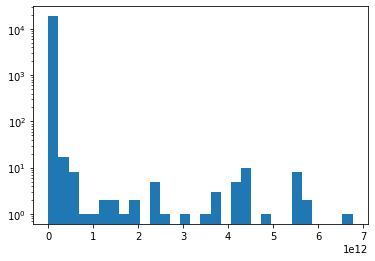

In [76]:
plt.hist(rewards, bins=30, log=True)
plt.show()

In [80]:
mybins = np.logspace(np.log10(min(rewards)), np.log10(max(rewards) + 1), 30 )
plt.hist(rewards, bins = mybins)
plt.xscale('log')
plt.yscale('log')
plt.show()

TypeError: Invalid argument, not a string or column: [6769820186921, 5773426182744, 5686886068346, 5572899146671, 5562639594981, 5540980646284, 5485933709548, 5485571462605, 5485196756539, 5485195404485, 5485194618183, 4832775896174, 4400612496814, 4400612495637, 4400600769270, 4389177926225, 4389164055897, 4336646221370, 4336637808213, 4328826406795, 4328817733069, 4328810343045, 4258866413724, 4258723913573, 4224986824918, 4217125583512, 4217120517417, 3736141031922, 3724635863184, 3664353267652, 3560532913046, 3049975251000, 2533062035819, 2461664921556, 2328669146206, 2297596282637, 2291765170871, 2289905182442, 1993407246560, 1821622660043, 1584941772141, 1384586019359, 1365557433234, 1238321126972, 1174379381446, 1084113281729, 889642101501, 592261612281, 586507798830, 584536036517, 572520208300, 527397955885, 524080853075, 473067688586, 465930273033, 442805520501, 438121619386, 385995799357, 345650190655, 332300332298, 330608000000, 326302508121, 323780402787, 308252781610, 308252781540, 300237755859, 294415345879, 271594304628, 262580086873, 260556172911, 254128675929, 246917658551, 220069216874, 180321720399, 180312306482, 180312306451, 167000464842, 166150166148, 162338168251, 158225726430, 157779530124, 144957010992, 135173776819, 130895950217, 127688661389, 127179432015, 123956404831, 120511968959, 116475219908, 116117574638, 112499104114, 106981963841, 106264035231, 105941296899, 105919239782, 105696284173, 103745479709, 96156771112, 91373880343, 90157035819, 89970217207, 85246540170, 82904497473, 81979341533, 80057021860, 79728919178, 79297550422, 71829619226, 68786920899, 68284027599, 68280947722, 60190628013, 59251802984, 58847580499, 58094873484, 55582511010, 51578321187, 51211109794, 51211109752, 49645938879, 48904413683, 48507886006, 47018903753, 45399610778, 45195519912, 45077416478, 45067252221, 44282028775, 44233016972, 44233011050, 44233007980, 44233002036, 44232989306, 44232983479, 43218626480, 43007407602, 42424169840, 38463863848, 37851939025, 37639126823, 37574850586, 37344131088, 35937280486, 35691047122, 33374053093, 33306853847, 33209968864, 32865866258, 31902603507, 31176434766, 31157018130, 31055749406, 30463391246, 29916450820, 29697068504, 28592866434, 28252897970, 27306120568, 27223496237, 26332405363, 26026102201, 26011111119, 25526248445, 25466726038, 25389307289, 25367741632, 25092856263, 22076130990, 22034588730, 21440694123, 21327492028, 21102141984, 21063354514, 20886911422, 20831769439, 20831769439, 20831769439, 20831769439, 20831769439, 20265979984, 20182851194, 20180574423, 19795362715, 19192915000, 19018294094, 18929017101, 18503616283, 17871535634, 17504568153, 17503670667, 16831966297, 16573200000, 16514600003, 16019983776, 15776319339, 15761527334, 14919426506, 14649458676, 14430853649, 13848835770, 13751326583, 13598322816, 13575882545, 13349628689, 13349628346, 13275011491, 12961987419, 12873415839, 12843927783, 12770533013, 12428612492, 12378476660, 12292426254, 12070362669, 12027438563, 12014872043, 12002462040, 11993033762, 11796212889, 11683092017, 11329151032, 11257711677, 11157489883, 10993910364, 10966756759, 10948980097, 10894148455, 10747798382, 10734620003, 10679626410, 10679626401, 10668994791, 10668994774, 10587500004, 10463464704, 10119575365, 10028230484, 10008794715, 10002264907, 9572849340, 9542228388, 9335264560, 9316856947, 9001939640, 8953050525, 8865416083, 8723989444, 8668647211, 8638071815, 8616176149, 8490362757, 8472579143, 8371728067, 8362062144, 8351295069, 8257600003, 8257600003, 8257600003, 8257600002, 8182137252, 7653833870, 7602320977, 7552634261, 7320342956, 7073139090, 7050310751, 6956943557, 6906846757, 6750899925, 6668924514, 6667985911, 6651681646, 6540476835, 6365000000, 6343826915, 6323208840, 6240308448, 6220618620, 6086025168, 5948829741, 5790224620, 5741757814, 5562723659, 5550479434, 5533476759, 5471387831, 5449954573, 5397034368, 5321856187, 5290493897, 5226287616, 5057802169, 5023562812, 5001207529, 4993584892, 4991277059, 4790429357, 4745158386, 4697684890, 4673429603, 4672569900, 4636886770, 4483544943, 4445565736, 4334427269, 4324013148, 4313954126, 4288466964, 4256137050, 4251331500, 4236531269, 4176508682, 4128750003, 4096687464, 4040122051, 4022019790, 4019988071, 3961000000, 3769780220, 3756198244, 3731956709, 3649297397, 3647562339, 3633289444, 3598940358, 3595042813, 3590225465, 3547102326, 3541310576, 3537325703, 3496390653, 3487758751, 3474145766, 3408039069, 3397295473, 3391130651, 3347422528, 3318097566, 3270099076, 3176861160, 3170791559, 3159130971, 3156725054, 3147459344, 3085912302, 3071189829, 3044168239, 2948456397, 2920464543, 2880434861, 2875757122, 2852590067, 2831829367, 2830949287, 2820303329, 2769608154, 2763836192, 2758084840, 2749545293, 2741048335, 2727214848, 2719795793, 2677294388, 2674354997, 2668171422, 2662705491, 2649687803, 2595814002, 2582398351, 2560299403, 2546929019, 2538128819, 2531456733, 2496797185, 2479205652, 2473428667, 2471933701, 2467359324, 2457051676, 2456388156, 2428522512, 2414101860, 2401251098, 2398523216, 2395049100, 2387492804, 2385184374, 2374874580, 2372254970, 2341366226, 2337443254, 2327766700, 2327025127, 2299254226, 2294251719, 2281943817, 2280541524, 2215616651, 2205000409, 2169203849, 2166531970, 2101501482, 2080593336, 2073136218, 2061751256, 2047042388, 2044805252, 2041838764, 2023283079, 2005769717, 1985955307, 1985515347, 1982214965, 1963665979, 1957245704, 1955697645, 1939560616, 1933729222, 1932243754, 1921715185, 1895782717, 1878398753, 1868198461, 1864782933, 1860003386, 1856866467, 1844619765, 1841905826, 1839304269, 1816938236, 1803154245, 1768538128, 1767074474, 1755924520, 1753673458, 1741035093, 1729099218, 1713579625, 1708707450, 1706948046, 1705307830, 1704764838, 1697909747, 1674492303, 1672294484, 1667297319, 1655213539, 1651894189, 1646140180, 1627818609, 1626577837, 1625448307, 1622610500, 1616780412, 1615452903, 1604399156, 1591259965, 1583133228, 1567207097, 1562800000, 1501457989, 1488257136, 1487015881, 1480693833, 1471761362, 1462526193, 1458310935, 1440714880, 1433028292, 1427345178, 1412897999, 1403214990, 1402509689, 1398726476, 1396558022, 1383284941, 1380283014, 1370944044, 1369133999, 1368951905, 1365485646, 1364696675, 1363564832, 1362737060, 1360724618, 1347871835, 1341948284, 1321850676, 1317949895, 1299722121, 1297753983, 1297584741, 1285727031, 1278712105, 1271814317, 1267987774, 1262957598, 1246856589, 1235657978, 1220826843, 1220499075, 1216067692, 1208871320, 1195612208, 1193212150, 1187095504, 1186843342, 1181392984, 1179243332, 1175533449, 1175411125, 1173272486, 1173021986, 1169957722, 1164459148, 1161150000, 1156998823, 1142533127, 1119867806, 1115945335, 1111428676, 1105414805, 1102946686, 1084854668, 1083328937, 1080823492, 1076224592, 1070441197, 1043682645, 1031344203, 1029562865, 1021631429, 1018210704, 1015126113, 1006353386, 1003144440, 998261268, 984774223, 977582273, 976943909, 976526807, 976526802, 974008358, 971362035, 965213112, 960285468, 957975830, 955337510, 950599991, 950418260, 947196574, 944899172, 943349339, 941454001, 940510439, 936149503, 919523848, 902829871, 900184291, 899427387, 897523156, 896968827, 891120730, 882175246, 881818636, 877041075, 866047302, 865782651, 852167727, 850613441, 850100000, 841901790, 840745341, 836919319, 836102021, 833242147, 822033927, 820641011, 816604965, 813283994, 797776234, 795136548, 788252509, 782742262, 782237986, 780282585, 767013672, 762816708, 757852227, 748238879, 747619190, 739639971, 736187334, 733604406, 731035771, 725894828, 724750000, 724355655, 722941654, 719434116, 713834282, 712897748, 706811944, 705042573, 690936491, 681273344, 680262008, 678544875, 678327814, 676778715, 676543327, 676344307, 674487450, 673297236, 672411155, 672125635, 671985780, 668569275, 663060535, 659867460, 656671733, 651037853, 651016314, 648044510, 647117187, 645824277, 644056449, 641027983, 638608765, 634252588, 633188835, 631678963, 625334033, 617611950, 612530961, 610494244, 607859704, 605572025, 604223772, 604212409, 599162326, 591107804, 586844062, 582242139, 579559540, 578634606, 576343292, 576187433, 574236465, 571343843, 571319508, 570884819, 570010059, 566324027, 566251221, 565100076, 562067590, 561711987, 558919619, 555691883, 555297734, 553951316, 550948614, 550433648, 548968349, 547361643, 543644792, 542294378, 542042450, 540777266, 540345318, 531482896, 529046339, 528210058, 526284863, 523674011, 522764226, 521614413, 521614413, 519087895, 518499977, 518154426, 516363741, 515805482, 515065110, 514687204, 514368256, 511660036, 511170015, 508340000, 507990448, 507520660, 504285023, 503365870, 503076554, 502881369, 502804998, 497298583, 488474480, 488294804, 485237219, 485176985, 484566786, 483832847, 482407856, 477992320, 475914935, 471074555, 469631100, 467708317, 465082460, 463844003, 463814563, 461366327, 460816341, 460667005, 460464658, 459387826, 459385726, 459382633, 454929460, 453420362, 452890220, 451154783, 449627797, 449613872, 448521405, 448489048, 447743425, 447246168, 446332079, 446040396, 444547631, 443703927, 443595223, 440170240, 437657165, 435813426, 435737696, 435419685, 434525997, 433543466, 433148940, 432513730, 428839762, 425875581, 420929908, 420189000, 418981711, 418970040, 418626050, 418326563, 418176027, 418078394, 417158821, 416509039, 416141649, 414775390, 414451436, 414240511, 413602263, 411689105, 409867057, 408417640, 403672191, 403552014, 403177500, 403175674, 402591285, 398315326, 395918170, 394982284, 394742679, 389344094, 388445895, 387467585, 383230705, 383019657, 382598188, 379824622, 379673149, 377603451, 376573347, 372715784, 369235322, 366015556, 365403384, 364827458, 363941062, 361311038, 359885799, 358352567, 356354897, 354548858, 354204177, 352666984, 352399166, 348535585, 347554916, 346003717, 344816000, 344711005, 341917149, 338301375, 336342088, 333183044, 332879766, 331829177, 331821158, 330736439, 329754393, 328812780, 327236193, 324909932, 324845044, 322875694, 321317220, 318866602, 318368101, 317682899, 316031160, 315253771, 314727378, 312867500, 312792904, 310295316, 309875607, 308375775, 307761935, 306750486, 306631428, 304853947, 304365811, 303041441, 301498890, 301055305, 300728312, 300708325, 299390608, 299124050, 294878848, 294307522, 293975750, 293971319, 293136340, 291865879, 290918616, 288099471, 287560599, 287456361, 286946525, 285758956, 285520871, 284263883, 284179181, 283316169, 281170860, 279678154, 275469873, 275451632, 275273007, 274538023, 274266032, 273921547, 273194571, 271636355, 271360091, 271023426, 269570191, 268910888, 268427261, 268124376, 268005768, 267184073, 266644863, 265783944, 265476503, 265006917, 264873000, 264239112, 261158750, 261063475, 260489284, 260011087, 259977263, 259502681, 257144962, 255950253, 254285422, 254117450, 252742598, 252126516, 251785985, 250432602, 250154074, 250153039, 249969610, 249335105, 248498063, 248027372, 247570014, 246824076, 246432882, 245899595, 245791652, 244965175, 244938151, 244886743, 244434600, 243185611, 241942043, 241107032, 239640745, 239265973, 237800830, 237566362, 237044083, 236236492, 236075294, 235794897, 235573903, 235271361, 234054964, 233457039, 233134095, 232861070, 231772934, 231188662, 229930141, 229447662, 229010785, 228968414, 226882079, 225739890, 225483150, 225099006, 224920962, 224323647, 224221698, 223977111, 223561523, 223536878, 223409258, 223388662, 223073380, 222839870, 222772684, 221324812, 220972740, 218971710, 218595355, 218201799, 218093852, 218073509, 217177618, 216512361, 216395536, 215341154, 215336105, 215104754, 215074113, 215002050, 214198774, 213789166, 212062701, 210991327, 210702905, 210388078, 210046661, 208964471, 208699800, 208047058, 207280395, 205878704, 205399733, 205186524, 203442200, 202958886, 202595443, 202498990, 202245736, 201608584, 201233165, 201026122, 200622966, 200564652, 200510311, 200464971, 200174390, 200163057, 199968918, 199461043, 199345863, 198552429, 198297976, 197629817, 197298302, 197165911, 196294716, 196100726, 195993135, 195843401, 195445022, 195396563, 195135873, 193113813, 192580044, 191579740, 191067008, 190816172, 190630113, 189895577, 189555338, 189362336, 189020448, 188977710, 188805438, 188186070, 187984743, 187499143, 187407478, 186541669, 185886964, 185859564, 185858067, 185857567, 184408916, 184163234, 183641493, 183633919, 183537983, 183333260, 183000904, 182462238, 181752059, 179069223, 178666889, 178400276, 178184606, 178054264, 177905826, 177885545, 177863103, 176441387, 175773968, 175463033, 174752368, 173855664, 173577961, 172794992, 172103654, 171307936, 171028224, 169521426, 169481151, 169458120, 168862508, 168739774, 168537852, 168259254, 167103502, 166580124, 166514458, 165324459, 164849459, 162522963, 162457597, 162295231, 162149949, 161603228, 161559529, 161463828, 161302932, 161258333, 161059474, 160966025, 160575957, 160380000, 159444983, 159368594, 159334002, 158335016, 157954161, 157391002, 157319492, 157240464, 156952188, 156883044, 155896664, 153895712, 153644484, 152877351, 152729345, 152521208, 152428524, 152366442, 152357687, 151716586, 151354342, 151079771, 150428931, 149758350, 146991380, 146819854, 146727109, 145301504, 145190472, 144972652, 144724919, 144545392, 144462339, 144366544, 144230709, 144104139, 143869328, 142964479, 141640863, 141054083, 140983276, 140241703, 140091834, 139593883, 139151659, 138398000, 138251068, 138055422, 137873424, 137707437, 137538444, 137367533, 136942729, 136874966, 135912606, 135088349, 134805000, 134403330, 134400908, 133599185, 132952916, 132452473, 132380994, 132163194, 131584842, 131356356, 131114471, 130853097, 130533701, 130491774, 130234230, 129982295, 128936160, 128779251, 128715832, 128457663, 128010839, 127748766, 126556319, 126497439, 126441456, 125309478, 124606248, 124088722, 123483360, 122733647, 121403855, 121396112, 121220152, 121207271, 121123478, 120989784, 120700219, 120631517, 120370414, 120078456, 119858424, 119661249, 119171247, 118995171, 118615399, 118377289, 118314902, 118074441, 117989210, 117735628, 117484256, 117446565, 117154083, 117078764, 117049043, 117043014, 116963990, 116961130, 116547340, 115368428, 115000629, 114812658, 114799865, 114683860, 114482808, 114385409, 114323372, 114231307, 113980877, 113713248, 112597116, 112462594, 111962077, 111642157, 111340639, 111140703, 110943773, 110865590, 110618326, 110464347, 109967948, 109715985, 109321992, 108681636, 108561192, 108380525, 107925001, 107843467, 107763656, 107754364, 107745259, 107709784, 107637495, 107569579, 107153390, 107023541, 106454900, 106264503, 105637321, 105378870, 105327003, 104721796, 104660202, 103606596, 103363664, 103331366, 103225361, 103210530, 103146702, 102837526, 102738938, 102292650, 102225159, 101561379, 101561104, 101124095, 100853317, 100821000, 100734521, 100279663, 100166030, 100097878, 100052449, 99979737, 99579116, 99505509, 99205438, 99146634, 99144042, 99075363, 98937338, 98828730, 98738933, 98422204, 98274115, 98263676, 98007624, 97908101, 96989424, 96859266, 96612321, 96554245, 96493851, 96491224, 96467946, 96331764, 96153363, 96120163, 96029305, 95938360, 95888410, 95751644, 95735833, 95642408, 95604817, 95599526, 95390096, 95053656, 95021550, 94978130, 94579265, 94389465, 94343536, 94115811, 93730464, 93719870, 93301634, 93239311, 93104745, 92648676, 92565322, 92260260, 92105576, 92095606, 91781339, 91770727, 91243949, 91107792, 91075418, 91073737, 90955683, 90706533, 90566563, 90546781, 90066050, 89670078, 89371915, 89334554, 89138820, 89079097, 88889546, 88824757, 88767647, 88690748, 88435308, 88050580, 87979895, 87624000, 87455891, 87138121, 86859835, 86807760, 86595921, 86344168, 86245450, 85769364, 85633475, 85553944, 85537353, 85469093, 85343980, 85340476, 85340000, 85340000, 85340000, 85340000, 85340000, 85340000, 85335980, 85333937, 85330000, 85330000, 85330000, 85330000, 85330000, 85330000, 85329937, 85327989, 85210000, 85210000, 85200000, 85058761, 84706266, 84378283, 84207495, 83698734, 83646121, 83447811, 82473375, 82157370, 82134916, 82131364, 81974610, 81460031, 80908965, 80780931, 80630175, 80578852, 80485065, 80415406, 79977734, 79728000, 79728000, 79728000, 79728000, 79728000, 79648273, 79647274, 79647274, 79647274, 79248324, 78979056, 78955095, 78907519, 78644080, 78514343, 78463671, 78237885, 78176484, 78173351, 78071998, 77763490, 77705024, 77625980, 77465933, 77410591, 77349979, 77146317, 76989823, 76843102, 76819646, 76605773, 76483982, 76373877, 76224875, 76224875, 76120291, 76022615, 76022571, 76022571, 76019436, 76019436, 76019436, 76019436, 75909382, 75883576, 75868572, 75756120, 75353637, 75295906, 75278561, 75128335, 75059702, 74613773, 74380323, 74281835, 73940233, 73714016, 73711256, 72998949, 72992000, 72761478, 72686016, 72569376, 72477521, 72347746, 72301685, 72240423, 72099314, 71422661, 71403357, 71139518, 70958369, 70784278, 70535341, 70434446, 70347826, 70283514, 70013953, 69940685, 69904919, 69825695, 69762429, 69752699, 69577844, 69528798, 69161184, 68805446, 68792666, 68741858, 68494557, 68232600, 68221350, 68194880, 68123677, 68118602, 68111493, 68108714, 68088520, 67830336, 67635268, 67450008, 67313702, 67303216, 67155207, 67119958, 67089272, 67002377, 66795701, 66758566, 66392970, 66266176, 66156597, 66114365, 66005424, 65974493, 65915698, 65902919, 65703291, 65390340, 65216111, 65160189, 64780425, 64775218, 64653595, 64599966, 64556280, 64519300, 64510018, 64503714, 64169825, 64139592, 64102953, 64003351, 63929352, 63372145, 63241760, 62654432, 62632212, 62631340, 62343469, 62260358, 62033402, 61819351, 61796819, 61691542, 61573167, 61302474, 61052036, 60945958, 60768857, 60534372, 60395088, 60145928, 59791907, 59771766, 59689560, 59459313, 59166225, 59027644, 58946746, 58929660, 58782761, 58714709, 58500749, 58422000, 58255105, 58125887, 58086473, 58081856, 58001298, 57799004, 57415342, 57208596, 57177120, 57103857, 57077201, 56899248, 56694336, 56599727, 56545617, 56498388, 56474173, 56411563, 56359800, 56227503, 56141258, 56110551, 55918614, 55819903, 55774413, 55643670, 55625437, 55520826, 55491001, 55489505, 55340205, 55331582, 55138017, 54756777, 54696400, 54695220, 54531914, 54455626, 54337071, 54327767, 54027865, 53940006, 53922685, 53912767, 53879486, 53837780, 53688295, 53625042, 53559249, 53293264, 53238216, 53141301, 53053396, 53010355, 52967793, 52797524, 52760142, 52745677, 52701918, 52677254, 52671373, 52631551, 52592670, 52325849, 52318257, 52201500, 52126053, 52078240, 51900631, 51890775, 51866103, 51748085, 51728794, 51567041, 51496703, 51409631, 51252088, 51192422, 51136431, 51118070, 51048144, 50994501, 50969228, 50854448, 50704021, 50683807, 50493007, 50445357, 50426724, 50219864, 50140908, 50035202, 50025864, 50024590, 49946738, 49892277, 49820979, 49666642, 49540263, 49526764, 49440785, 49408760, 49289337, 49251541, 49110360, 49063860, 49015556, 49009288, 48979343, 48895253, 48876403, 48858678, 48829940, 48721424, 48686752, 48505909, 48418217, 48290848, 48287458, 48239194, 48084620, 47960258, 47904578, 47805000, 47796253, 47731110, 47263480, 47252488, 47225916, 47078181, 47017819, 46887765, 46832249, 46789479, 46783963, 46622245, 46504111, 46480358, 46471965, 46383779, 46299911, 46276131, 46101584, 46010071, 45960195, 45890965, 45890964, 45890964, 45890964, 45677157, 45643424, 45634823, 45616864, 45610720, 45565724, 45552204, 45507738, 45500935, 45344544, 45225571, 45147807, 45141035, 45135514, 45101172, 45091012, 45057545, 44983938, 44924540, 44753336, 44603785, 44580555, 44518598, 44208061, 44140754, 44070000, 44037996, 43948325, 43899772, 43784888, 43753635, 43738064, 43724283, 43631904, 43593202, 43544687, 43250437, 42936000, 42928901, 42899682, 42854045, 42806985, 42701800, 42645829, 42585901, 42464131, 42409383, 42406946, 42396802, 42353345, 42322976, 42163602, 42112255, 41892263, 41876780, 41769005, 41765114, 41722092, 41645120, 41586670, 41564998, 41462767, 41395554, 41277598, 41225951, 41186100, 41132076, 41071788, 40913975, 40875394, 40874385, 40872396, 40848579, 40698601, 40610907, 40540902, 40482937, 40433736, 40368216, 40354423, 40339256, 40176558, 40162314, 40129797, 39991664, 39974115, 39962694, 39768642, 39767041, 39678862, 39543341, 39516390, 39516389, 39481271, 39398870, 39340572, 39294690, 39251745, 39120959, 39084172, 39057806, 39007824, 39000593, 38915007, 38784538, 38777976, 38584071, 38558559, 38539565, 38539340, 38441700, 38396079, 38387874, 38338154, 38319172, 38317880, 38283384, 38273787, 38168286, 38090788, 37992752, 37931111, 37929216, 37752362, 37720600, 37681588, 37672153, 37586074, 37529468, 37360950, 37323209, 37284472, 37225224, 37217588, 37173535, 37172940, 37104009, 37080904, 36970388, 36862623, 36835147, 36708626, 36674030, 36626681, 36498032, 36333069, 36251237, 36146228, 36143733, 36101796, 35969463, 35899866, 35862356, 35852269, 35779046, 35745726, 35688423, 35543566, 35499197, 35349390, 35253481, 35221788, 35218747, 35150831, 34946794, 34903012, 34837307, 34828150, 34809112, 34806232, 34743564, 34726438, 34700000, 34591118, 34385946, 34377772, 34357785, 34288829, 34281223, 34272543, 34264483, 34239569, 34199036, 34097821, 34043884, 33983139, 33917528, 33805897, 33799080, 33741967, 33655122, 33623662, 33482636, 33439520, 33439102, 33422528, 33378813, 33309819, 33155565, 33141080, 33141037, 33128572, 33064502, 33056053, 32986732, 32973924, 32961677, 32939330, 32836676, 32739682, 32735824, 32670768, 32657403, 32629332, 32554356, 32519245, 32453953, 32443224, 32411710, 32375526, 32328400, 32298015, 32242989, 32089143, 31972154, 31939729, 31894325, 31874796, 31823743, 31730545, 31704882, 31628761, 31541045, 31508575, 31507526, 31332084, 31330020, 31291119, 31270570, 31228935, 31142621, 31132511, 31075197, 30916571, 30812352, 30792843, 30619547, 30610446, 30490130, 30482770, 30339402, 30270730, 30235496, 30190799, 30154240, 30130703, 30129381, 30122288, 29898886, 29873148, 29870212, 29850013, 29847903, 29777316, 29579502, 29577567, 29559337, 29544320, 29543616, 29537390, 29491238, 29490000, 29488954, 29464953, 29460796, 29448875, 29442560, 29381971, 29350787, 29283101, 29279506, 29247420, 29219819, 29208698, 29186876, 29106786, 29045574, 29023148, 28906696, 28713949, 28653741, 28545118, 28504093, 28472404, 28382461, 28352484, 28256854, 28211458, 28177773, 28149643, 28073131, 28012694, 27973894, 27927048, 27780146, 27747139, 27726124, 27681867, 27665571, 27619355, 27602892, 27600000, 27534047, 27506174, 27485873, 27402312, 27398238, 27397401, 27396372, 27344926, 27338155, 27259367, 27245352, 27140676, 27101213, 27073439, 27048802, 27006628, 27004464, 26963709, 26944584, 26935785, 26905647, 26869806, 26826587, 26732897, 26730143, 26716750, 26710632, 26614461, 26558932, 26539579, 26454000, 26407954, 26382878, 26382767, 26366057, 26362017, 26352320, 26311620, 26229648, 26158978, 26135069, 26127718, 26125073, 26097746, 26040374, 26017557, 26015440, 26008355, 25966946, 25881851, 25827839, 25825916, 25797032, 25785456, 25771048, 25646238, 25591495, 25566852, 25548645, 25546800, 25432168, 25425076, 25348262, 25345436, 25334636, 25273417, 25255159, 25239194, 25195703, 25176707, 25138335, 25130381, 25110000, 25090049, 25041646, 24964956, 24910024, 24819650, 24776460, 24724140, 24684058, 24583681, 24567578, 24562500, 24544140, 24499655, 24491893, 24442680, 24390455, 24382651, 24333080, 24314853, 24307194, 24293682, 24184913, 24065499, 24060030, 24009185, 23987830, 23960328, 23872314, 23858714, 23855718, 23847492, 23767285, 23710993, 23705617, 23704646, 23682475, 23673090, 23581411, 23541585, 23503698, 23438363, 23405552, 23271360, 23204612, 23062300, 22978174, 22949218, 22943609, 22893986, 22864173, 22858363, 22844808, 22788610, 22785950, 22774616, 22759786, 22756060, 22743200, 22511580, 22455163, 22445754, 22440925, 22431583, 22418898, 22415131, 22376854, 22374522, 22283768, 22165928, 22144018, 22125000, 22098410, 22084104, 22084072, 22070304, 22021404, 21987984, 21978365, 21889732, 21816542, 21762816, 21732815, 21703114, 21683092, 21659717, 21633378, 21632609, 21621888, 21615882, 21596184, 21586523, 21573858, 21552666, 21547998, 21533824, 21412945, 21403580, 21328741, 21201460, 21179204, 21162659, 21158201, 21087773, 21072679, 21054746, 21036598, 20968446, 20968196, 20964580, 20914560, 20885355, 20885170, 20881517, 20862590, 20832560, 20725749, 20663952, 20616492, 20584532, 20526266, 20521889, 20487064, 20483305, 20477576, 20455322, 20445785, 20416611, 20401708, 20383434, 20378772, 20369518, 20350899, 20283691, 20223180, 20196665, 20166226, 20165625, 20161116, 20094156, 20088000, 19989448, 19939476, 19889088, 19861640, 19841924, 19820276, 19747400, 19737390, 19727701, 19699005, 19632396, 19587134, 19558761, 19531784, 19503636, 19393686, 19389934, 19301664, 19297228, 19291500, 19283172, 19251285, 19189326, 19183473, 19163704, 19131338, 19116345, 19099933, 19071218, 19014933, 18974308, 18932064, 18931644, 18918408, 18840990, 18836184, 18803955, 18800799, 18779989, 18730165, 18722708, 18624947, 18618094, 18572238, 18479795, 18436927, 18430736, 18426703, 18421851, 18382325, 18372784, 18347838, 18339564, 18338250, 18296721, 18276544, 18276172, 18274031, 18204792, 18200246, 18190996, 18177164, 18172648, 18167427, 18132228, 18128924, 18127242, 18109791, 18092626, 18085051, 18061473, 18053773, 18051330, 18020220, 18005368, 17976528, 17976275, 17964465, 17926766, 17926095, 17902564, 17845308, 17811876, 17723130, 17722800, 17722538, 17673487, 17655701, 17649861, 17633572, 17589658, 17579540, 17573387, 17540838, 17537989, 17484197, 17477359, 17466854, 17457197, 17447208, 17379425, 17378546, 17367828, 17362066, 17323014, 17318074, 17310696, 17302222, 17282209, 17242951, 17209656, 17189309, 17167285, 17148642, 17140916, 17118772, 17117043, 17101841, 17093314, 17082565, 17072280, 17039060, 17007856, 16963710, 16934824, 16933410, 16923984, 16913739, 16759440, 16722202, 16681167, 16634280, 16630085, 16618176, 16597654, 16593640, 16565194, 16552207, 16548687, 16548382, 16530196, 16529812, 16505016, 16502691, 16500748, 16378961, 16373916, 16371725, 16311120, 16281843, 16256832, 16239634, 16215402, 16179498, 16151958, 16145670, 16140034, 16140000, 16095372, 16092015, 16088138, 15995857, 15983581, 15967574, 15950356, 15950181, 15945978, 15921750, 15873636, 15857503, 15845007, 15743586, 15727084, 15673926, 15673177, 15641919, 15632444, 15580110, 15565864, 15534164, 15500602, 15498782, 15498680, 15434332, 15431595, 15428814, 15422964, 15387769, 15364623, 15356328, 15289717, 15282468, 15235342, 15210336, 15195595, 15128802, 15103836, 15082482, 15048522, 15022504, 15000028, 14894580, 14890526, 14844325, 14798448, 14796574, 14761623, 14692064, 14685950, 14676028, 14652398, 14638552, 14600900, 14594234, 14582003, 14546349, 14531535, 14524965, 14507042, 14473494, 14459928, 14429225, 14408212, 14373932, 14334341, 14333985, 14325897, 14311248, 14303418, 14300561, 14288689, 14274027, 14262110, 14247285, 14214148, 14151021, 14141750, 14101850, 14099225, 14086828, 14081382, 14064449, 14063964, 14049021, 14031360, 14029749, 14022598, 14008672, 13992727, 13961933, 13932417, 13916869, 13891949, 13857940, 13847087, 13841062, 13839546, 13832548, 13829474, 13818200, 13797350, 13796559, 13788050, 13776936, 13722627, 13722202, 13666165, 13654535, 13641012, 13622650, 13566134, 13556588, 13510862, 13471602, 13458071, 13442554, 13435084, 13379339, 13352566, 13344211, 13341181, 13328524, 13328000, 13310500, 13298170, 13273843, 13273296, 13263390, 13258763, 13252405, 13247436, 13237198, 13207814, 13178035, 13170218, 13151264, 13115570, 13105135, 13099911, 13083931, 13061012, 13032958, 12882689, 12882642, 12863630, 12854826, 12852727, 12851716, 12845808, 12826210, 12820762, 12789451, 12763657, 12694151, 12685195, 12678668, 12665751, 12658460, 12635046, 12631088, 12613245, 12602752, 12600000, 12592785, 12584904, 12553452, 12545628, 12503010, 12496740, 12484392, 12459214, 12449187, 12429774, 12429320, 12429044, 12408562, 12407950, 12391896, 12389918, 12382076, 12368089, 12317468, 12284300, 12265646, 12261392, 12238071, 12224848, 12200007, 12193606, 12191854, 12147978, 12142306, 12140150, 12135406, 12100167, 12096384, 12053600, 12036625, 12028291, 11994652, 11950421, 11940755, 11939004, 11932185, 11897343, 11897161, 11890627, 11870905, 11870208, 11862629, 11854341, 11840877, 11819520, 11811643, 11809312, 11799761, 11787581, 11760404, 11702953, 11701506, 11673206, 11661552, 11639536, 11622344, 11559878, 11549009, 11540818, 11537000, 11524566, 11519031, 11499710, 11487395, 11478294, 11478284, 11467496, 11460967, 11460143, 11451467, 11431508, 11424942, 11424020, 11420366, 11389855, 11389392, 11382417, 11372715, 11336548, 11317740, 11296483, 11287651, 11277013, 11246550, 11226550, 11224579, 11204361, 11199699, 11195538, 11167905, 11150172, 11116088, 11111404, 11110234, 11065219, 11046648, 11045739, 11044800, 11011014, 10962536, 10962013, 10932808, 10931211, 10929200, 10922344, 10905201, 10901064, 10889558, 10887280, 10880184, 10858558, 10836322, 10833088, 10830000, 10827034, 10816004, 10809650, 10803678, 10797728, 10772678, 10770900, 10763942, 10760708, 10759190, 10742184, 10731151, 10700000, 10688636, 10675738, 10671461, 10665870, 10660000, 10651099, 10630510, 10607075, 10607052, 10591154, 10590216, 10543722, 10530612, 10529039, 10526326, 10497517, 10484150, 10455750, 10445797, 10441308, 10437910, 10435886, 10382513, 10362222, 10328710, 10319614, 10317502, 10310938, 10296922, 10252305, 10251929, 10250957, 10236811, 10220622, 10200000, 10192663, 10190564, 10171740, 10164578, 10141501, 10132043, 10129807, 10081798, 10080398, 10079811, 10078397, 10070440, 10062904, 10058019, 10055422, 10048253, 10039771, 10036539, 10020000, 10018118, 9981872, 9960096, 9957255, 9956133, 9941982, 9937077, 9928402, 9922482, 9903764, 9899349, 9894509, 9892833, 9890594, 9889929, 9888296, 9879506, 9867021, 9864415, 9811232, 9799764, 9799680, 9780049, 9773988, 9721320, 9719750, 9719000, 9698093, 9684656, 9659470, 9658387, 9639585, 9627618, 9621882, 9619244, 9600521, 9599376, 9598400, 9562600, 9551830, 9545210, 9516351, 9510858, 9508858, 9508787, 9499428, 9492872, 9477409, 9473587, 9461891, 9439278, 9402473, 9396762, 9373344, 9370650, 9333401, 9333256, 9302592, 9301763, 9299046, 9281797, 9281428, 9232632, 9226995, 9224320, 9193220, 9189468, 9147519, 9139650, 9121576, 9107269, 9096520, 9092112, 9085839, 9084348, 9081524, 9067329, 9065896, 9065623, 9048673, 9043837, 9026250, 9022085, 9020749, 9012565, 9012099, 9009699, 8993025, 8965692, 8951446, 8903562, 8902501, 8900710, 8895848, 8878965, 8878143, 8877077, 8851306, 8846595, 8842052, 8841672, 8832313, 8828544, 8804625, 8775000, 8749116, 8737706, 8736305, 8729100, 8721700, 8717948, 8713446, 8701879, 8701875, 8696317, 8683512, 8672570, 8672388, 8631075, 8629073, 8611467, 8594562, 8591367, 8589500, 8573328, 8569754, 8555684, 8539146, 8531052, 8511526, 8496002, 8493680, 8447058, 8428000, 8421630, 8417525, 8411585, 8411563, 8396900, 8388975, 8371782, 8366897, 8343776, 8337252, 8322226, 8311778, 8289216, 8285388, 8270977, 8259005, 8256038, 8254000, 8242325, 8223376, 8218355, 8218181, 8204183, 8184958, 8181948, 8179060, 8177343, 8171841, 8170562, 8168694, 8166260, 8163030, 8152928, 8142694, 8142233, 8132248, 8131106, 8125643, 8115388, 8088676, 8086053, 8083615, 8078704, 8076660, 8067153, 8040000, 8039949, 8026304, 8025165, 8017386, 8016300, 8014787, 8002300, 8002070, 7976755, 7950543, 7939556, 7929998, 7928536, 7923685, 7914542, 7912275, 7896564, 7863017, 7857879, 7855421, 7835840, 7832215, 7830993, 7811724, 7807311, 7804143, 7801107, 7772024, 7770112, 7746915, 7746436, 7738368, 7716546, 7707275, 7678336, 7668404, 7665042, 7664750, 7644469, 7637638, 7631724, 7624232, 7615296, 7609840, 7602316, 7600000, 7599962, 7599920, 7594547, 7590560, 7581548, 7573745, 7571439, 7571400, 7559838, 7553885, 7552922, 7522946, 7504112, 7486991, 7482561, 7477426, 7474212, 7444353, 7435681, 7432973, 7429478, 7427565, 7425600, 7423955, 7415224, 7404252, 7388532, 7385769, 7373292, 7366116, 7363741, 7356900, 7336953, 7303142, 7286382, 7283374, 7276338, 7265992, 7256439, 7248536, 7246196, 7245897, 7232794, 7227211, 7225103, 7217288, 7198454, 7191288, 7189842, 7178038, 7177938, 7177938, 7177938, 7177938, 7177938, 7177935, 7177935, 7177838, 7177838, 7177838, 7172659, 7171821, 7114610, 7112911, 7112524, 7103600, 7102849, 7099144, 7077883, 7067167, 7062370, 7061614, 7059256, 7056965, 7053979, 7039390, 7021622, 7020148, 7010448, 6994056, 6980580, 6969984, 6963148, 6956021, 6928608, 6925920, 6918879, 6917952, 6910588, 6905405, 6905034, 6881820, 6870870, 6837872, 6829727, 6825654, 6814168, 6809188, 6774481, 6768682, 6735742, 6727216, 6721698, 6708789, 6706432, 6704725, 6703131, 6697146, 6694488, 6693831, 6691400, 6690996, 6685103, 6671436, 6671214, 6669590, 6669373, 6668750, 6666043, 6656250, 6652540, 6651678, 6646952, 6634222, 6633326, 6632598, 6625926, 6618750, 6617816, 6603629, 6595644, 6590774, 6531391, 6531018, 6519276, 6500789, 6497600, 6490513, 6489509, 6485127, 6485002, 6481475, 6463118, 6461713, 6446796, 6437377, 6418368, 6372791, 6372097, 6371687, 6369274, 6366958, 6362114, 6355224, 6346028, 6340559, 6333223, 6331232, 6328257, 6327369, 6323721, 6309100, 6303692, 6302304, 6300000, 6299265, 6291709, 6290128, 6282548, 6278300, 6276604, 6275662, 6264328, 6263155, 6256918, 6234426, 6234341, 6226410, 6222510, 6206759, 6196973, 6194658, 6194188, 6193471, 6173897, 6167388, 6144837, 6144041, 6137113, 6135694, 6124320, 6123630, 6123474, 6121984, 6117623, 6113713, 6108662, 6083451, 6078972, 6062719, 6049054, 6047447, 6044940, 6033810, 6027756, 6024588, 6018903, 6012289, 6008820, 6004918, 6000761, 5995354, 5992200, 5990157, 5988579, 5970176, 5955048, 5948254, 5939680, 5938846, 5923554, 5920227, 5915656, 5914345, 5913408, 5908344, 5907555, 5903050, 5893702, 5887299, 5884480, 5882626, 5868769, 5865484, 5857738, 5851252, 5846400, 5842665, 5819685, 5816313, 5814723, 5803213, 5795363, 5782722, 5780733, 5759361, 5750779, 5742761, 5736610, 5735995, 5735562, 5716944, 5704652, 5700912, 5700665, 5699405, 5673456, 5673422, 5672710, 5671437, 5664360, 5663957, 5663570, 5647520, 5633610, 5623626, 5610593, 5610366, 5602487, 5587850, 5570240, 5569190, 5556860, 5550935, 5548672, 5548368, 5548347, 5547707, 5546113, 5542456, 5536638, 5527974, 5522706, 5515903, 5507813, 5501757, 5497604, 5490456, 5483097, 5480711, 5479699, 5474238, 5473879, 5472233, 5466919, 5465460, 5450117, 5447319, 5438640, 5436422, 5431170, 5428215, 5428100, 5426400, 5424615, 5423611, 5419414, 5409152, 5403098, 5401462, 5396144, 5370000, 5358591, 5355000, 5344560, 5343917, 5343141, 5342888, 5339637, 5329467, 5328783, 5325192, 5309573, 5308352, 5287333, 5285628, 5285120, 5276127, 5248932, 5233306, 5225480, 5224496, 5222963, 5222143, 5210718, 5195466, 5190300, 5175457, 5173801, 5172010, 5169032, 5167447, 5161683, 5161174, 5159925, 5157360, 5155737, 5153054, 5139090, 5129369, 5126382, 5124142, 5120262, 5119568, 5119292, 5119150, 5110323, 5109520, 5090238, 5090041, 5085785, 5082328, 5071280, 5044646, 5044491, 5032178, 5032000, 5022871, 5022320, 5021000, 5012586, 4981790, 4968286, 4958930, 4951456, 4946041, 4932320, 4932103, 4926910, 4923828, 4921460, 4914810, 4913799, 4913646, 4909543, 4905183, 4902178, 4901946, 4894564, 4884460, 4884359, 4879765, 4876176, 4872534, 4870042, 4864576, 4863261, 4862399, 4860766, 4850000, 4847615, 4837798, 4827435, 4822704, 4819992, 4816095, 4812764, 4806750, 4796643, 4782018, 4781004, 4769614, 4769280, 4760425, 4759320, 4758864, 4758000, 4747773, 4737017, 4730288, 4722540, 4713625, 4712826, 4707213, 4692669, 4692207, 4677437, 4675122, 4671164, 4666113, 4665309, 4642925, 4640438, 4634287, 4632042, 4621095, 4620931, 4619571, 4618080, 4616959, 4606072, 4604350, 4599712, 4598440, 4581486, 4580225, 4580225, 4568992, 4568719, 4567054, 4540104, 4539962, 4536168, 4518937, 4512379, 4510441, 4507250, 4502240, 4501579, 4498611, 4498302, 4488988, 4486737, 4478916, 4475170, 4473344, 4468500, 4451321, 4451119, 4449009, 4438224, 4436812, 4433956, 4430700, 4408257, 4407564, 4402320, 4399164, 4396409, 4386846, 4386710, 4375394, 4375380, 4368272, 4365661, 4364661, 4362674, 4354080, 4349805, 4348840, 4348395, 4348013, 4344734, 4344712, 4338394, 4338181, 4337721, 4334002, 4327840, 4314507, 4310415, 4307644, 4307516, 4304746, 4303350, 4288714, 4275000, 4273083, 4273005, 4271110, 4270204, 4268750, 4264707, 4264379, 4262544, 4255048, 4247866, 4247439, 4241874, 4237275, 4233053, 4230142, 4230043, 4229757, 4227006, 4226725, 4219371, 4217409, 4212479, 4211947, 4208670, 4204913, 4197859, 4191552, 4183986, 4180558, 4178953, 4173669, 4173333, 4170983, 4168768, 4161888, 4158274, 4157668, 4157025, 4144200, 4143450, 4142965, 4136550, 4131976, 4131139, 4125483, 4121640, 4114452, 4110366, 4105920, 4099049, 4092953, 4091088, 4079712, 4079600, 4071548, 4060943, 4053099, 4050143, 4042290, 4040510, 4012290, 3998919, 3997957, 3995904, 3989126, 3988310, 3980560, 3977524, 3974675, 3974248, 3974142, 3973536, 3970278, 3969128, 3968430, 3964550, 3964257, 3955900, 3955286, 3951760, 3951012, 3933326, 3931297, 3928470, 3928065, 3927901, 3920571, 3918018, 3909290, 3908962, 3903329, 3898443, 3897281, 3886111, 3884864, 3874304, 3857829, 3843850, 3837750, 3837454, 3834956, 3829856, 3828694, 3819512, 3814542, 3814131, 3809307, 3804557, 3803802, 3802505, 3789780, 3787514, 3786915, 3783817, 3779544, 3773261, 3773076, 3767965, 3766392, 3761316, 3760500, 3757744, 3757261, 3757255, 3755898, 3751065, 3744068, 3742254, 3737268, 3732552, 3732302, 3728778, 3717350, 3716373, 3714613, 3712551, 3699632, 3699193, 3697312, 3694349, 3694129, 3692734, 3686992, 3686843, 3682732, 3673644, 3667360, 3665430, 3663008, 3660267, 3655586, 3637765, 3631410, 3629694, 3625935, 3621858, 3619011, 3618000, 3605761, 3601724, 3599166, 3598745, 3593622, 3591106, 3589718, 3589371, 3585721, 3579821, 3578776, 3573738, 3569168, 3561064, 3560744, 3560380, 3557296, 3552652, 3544310, 3542292, 3535590, 3534336, 3530575, 3530139, 3515628, 3503766, 3502000, 3495779, 3495625, 3495606, 3488690, 3487103, 3483952, 3483128, 3480077, 3479620, 3477462, 3476010, 3475248, 3470783, 3469679, 3466475, 3463534, 3462287, 3457205, 3451855, 3451721, 3448069, 3445450, 3436901, 3436828, 3434796, 3434508, 3427869, 3415148, 3409947, 3404288, 3403680, 3401825, 3398201, 3393373, 3392003, 3379164, 3363010, 3360572, 3358243, 3357184, 3353853, 3350970, 3348702, 3343564, 3333768, 3330864, 3325989, 3325740, 3321014, 3317936, 3316094, 3315186, 3312930, 3312295, 3312000, 3309647, 3309625, 3309434, 3309434, 3309434, 3309434, 3308929, 3295917, 3295136, 3293433, 3291756, 3291001, 3290739, 3289560, 3288167, 3287452, 3284969, 3280006, 3276737, 3275391, 3269444, 3268020, 3267685, 3266249, 3265064, 3256357, 3255000, 3240001, 3239616, 3237829, 3237766, 3236545, 3234000, 3232359, 3232138, 3230252, 3224466, 3218454, 3217950, 3217429, 3216015, 3212331, 3210012, 3209310, 3206404, 3206203, 3198096, 3197668, 3196172, 3191514, 3191230, 3184280, 3184150, 3176779, 3172854, 3165704, 3165325, 3162690, 3161730, 3160648, 3159204, 3159000, 3150592, 3147417, 3146280, 3138749, 3136984, 3132391, 3131590, 3122435, 3121008, 3115824, 3115702, 3113626, 3112618, 3102921, 3098076, 3094274, 3093990, 3093000, 3087972, 3087798, 3086536, 3086234, 3085413, 3072186, 3069673, 3063586, 3061223, 3060570, 3058541, 3054863, 3054240, 3053277, 3044096, 3043169, 3039038, 3038773, 3027618, 3027530, 3027437, 3022264, 3014262, 3006130, 2999999, 2996274, 2994441, 2994034, 2992928, 2991768, 2983096, 2981742, 2968032, 2967851, 2967690, 2962518, 2954299, 2953679, 2953098, 2950247, 2948139, 2944631, 2942868, 2942500, 2925960, 2923375, 2918993, 2918407, 2916376, 2916061, 2914768, 2914390, 2913729, 2910716, 2910360, 2907756, 2895984, 2891644, 2890826, 2885920, 2881439, 2873640, 2873408, 2868784, 2860439, 2858076, 2856535, 2856426, 2854797, 2852720, 2852592, 2851625, 2848800, 2848188, 2845286, 2845033, 2842060, 2840094, 2836330, 2835040, 2834000, 2831439, 2831254, 2828925, 2828634, 2826768, 2825216, 2820000, 2818108, 2815936, 2813943, 2813228, 2811511, 2811237, 2809437, 2807376, 2806009, 2805369, 2805324, 2803110, 2802050, 2799860, 2799456, 2797815, 2797219, 2793267, 2792760, 2791500, 2787460, 2784781, 2784570, 2777232, 2773520, 2772585, 2770287, 2770074, 2766301, 2764388, 2764200, 2760570, 2758417, 2753169, 2750326, 2745507, 2738142, 2735064, 2728996, 2727620, 2726751, 2726673, 2726373, 2724920, 2724601, 2722638, 2719765, 2717855, 2716744, 2716424, 2714381, 2714046, 2713124, 2711978, 2711250, 2696820, 2694632, 2690688, 2686920, 2684787, 2682680, 2681320, 2680925, 2666360, 2665000, 2663050, 2662303, 2660730, 2652805, 2650176, 2649820, 2644123, 2639652, 2637180, 2631889, 2625930, 2625526, 2623128, 2622452, 2616830, 2612879, 2610986, 2608140, 2607120, 2595413, 2586751, 2581966, 2576010, 2573805, 2572905, 2572593, 2571850, 2570711, 2560799, 2557109, 2556994, 2556436, 2549531, 2547857, 2547662, 2547120, 2546020, 2542848, 2542428, 2535971, 2534786, 2534196, 2532756, 2531972, 2530542, 2519999, 2519264, 2519178, 2518251, 2516930, 2516690, 2509689, 2508936, 2505910, 2503254, 2503090, 2499568, 2498804, 2491997, 2491931, 2489806, 2489121, 2487060, 2486191, 2484992, 2483518, 2480866, 2479567, 2478000, 2476728, 2473000, 2471557, 2470044, 2469090, 2466750, 2465791, 2463760, 2463054, 2462880, 2459731, 2455621, 2451842, 2451753, 2450720, 2448291, 2445220, 2441140, 2439903, 2432280, 2430512, 2415148, 2414400, 2412840, 2409007, 2407110, 2403234, 2400564, 2392257, 2391749, 2391480, 2388199, 2386995, 2385600, 2384726, 2384441, 2382167, 2379800, 2378356, 2374428, 2372772, 2370446, 2368961, 2368928, 2367667, 2366000, 2362170, 2361214, 2357973, 2357235, 2356107, 2354040, 2352860, 2352194, 2352142, 2350938, 2348732, 2348710, 2346825, 2342310, 2341334, 2340726, 2340090, 2340034, 2338765, 2337655, 2337403, 2334801, 2334796, 2329453, 2325243, 2319626, 2318602, 2314448, 2313283, 2313042, 2312490, 2311500, 2308319, 2307053, 2306800, 2304432, 2300523, 2300405, 2299900, 2295781, 2291668, 2289591, 2289519, 2288719, 2287731, 2287342, 2281272, 2281140, 2281037, 2278225, 2276109, 2275340, 2272293, 2270634, 2268238, 2265980, 2265722, 2263099, 2262965, 2261429, 2255700, 2255332, 2255000, 2253700, 2253332, 2248326, 2246850, 2246552, 2244160, 2242976, 2236231, 2233051, 2228447, 2226881, 2226700, 2224915, 2223550, 2220648, 2220264, 2212981, 2212852, 2212364, 2209284, 2208350, 2205430, 2204688, 2204487, 2196806, 2192131, 2192000, 2189484, 2189336, 2184823, 2182907, 2178622, 2178132, 2176000, 2164301, 2164000, 2162835, 2160142, 2155371, 2154000, 2152254, 2145706, 2145171, 2141898, 2139604, 2138120, 2131824, 2129595, 2129250, 2125530, 2124432, 2122680, 2121141, 2119554, 2119322, 2110649, 2110480, 2108981, 2105972, 2104258, 2104112, 2102307, 2100960, 2100906, 2099847, 2098006, 2094679, 2094162, 2092992, 2090812, 2087940, 2087096, 2085256, 2084957, 2083758, 2082291, 2081547, 2081408, 2080541, 2073501, 2073077, 2072823, 2071525, 2069279, 2069119, 2058813, 2057387, 2056606, 2056209, 2052610, 2051594, 2051025, 2050624, 2048274, 2045456, 2045046, 2033719, 2033025, 2029438, 2029345, 2029092, 2028280, 2027300, 2026905, 2026527, 2026112, 2025478, 2021076, 2017638, 2016000, 2013151, 2012571, 2011454, 2010290, 2006107, 2005087, 2001584, 2000160, 2000002, 2000000, 2000000, 1999990, 1996946, 1994436, 1992120, 1990500, 1985274, 1985065, 1984421, 1984138, 1981624, 1978830, 1973430, 1972990, 1971039, 1967466, 1962109, 1958800, 1957917, 1955970, 1955654, 1954400, 1954350, 1953525, 1952025, 1950727, 1950727, 1950727, 1950727, 1950727, 1950727, 1950727, 1950727, 1950726, 1950500, 1948104, 1947739, 1944000, 1942775, 1938656, 1938535, 1934944, 1933589, 1932122, 1931595, 1931425, 1927586, 1927162, 1925423, 1925308, 1919500, 1918280, 1916644, 1914273, 1913925, 1912855, 1912428, 1912016, 1911400, 1908728, 1907966, 1907750, 1906814, 1904175, 1903502, 1900935, 1897892, 1897360, 1894513, 1893306, 1891300, 1890312, 1890238, 1887435, 1886287, 1878976, 1877810, 1876502, 1875056, 1874602, 1873402, 1873101, 1871492, 1870045, 1868975, 1868883, 1863750, 1861120, 1858834, 1852972, 1852818, 1851189, 1850715, 1849738, 1848753, 1842603, 1837500, 1836768, 1836424, 1833120, 1831242, 1827698, 1827360, 1826329, 1823954, 1820788, 1820240, 1820050, 1818660, 1815819, 1814900, 1814114, 1813383, 1813381, 1812038, 1810813, 1810522, 1809500, 1807633, 1805517, 1804768, 1804153, 1803550, 1803325, 1801980, 1800000, 1798878, 1795958, 1793397, 1791176, 1790933, 1790375, 1787970, 1784404, 1782780, 1782319, 1779960, 1778362, 1776661, 1774110, 1772000, 1770306, 1766232, 1763243, 1759849, 1757944, 1754455, 1753925, 1753548, 1750184, 1749904, 1749600, 1748610, 1745851, 1744400, 1744350, 1741306, 1740765, 1739760, 1739604, 1738417, 1737108, 1733791, 1731144, 1730162, 1729637, 1728980, 1726268, 1724974, 1724949, 1722711, 1722632, 1722516, 1719530, 1717473, 1713914, 1712256, 1712062, 1710565, 1710000, 1707542, 1707180, 1706900, 1705644, 1705363, 1705147, 1695908, 1694690, 1690825, 1690000, 1688338, 1686454, 1686398, 1685777, 1685375, 1683704, 1682688, 1682481, 1677161, 1675900, 1666787, 1666095, 1665876, 1664343, 1662606, 1660364, 1660271, 1660000, 1657392, 1657350, 1657138, 1656960, 1654344, 1652113, 1650313, 1648881, 1648690, 1647735, 1646655, 1646380, 1645755, 1643565, 1640164, 1640164, 1638906, 1635282, 1634714, 1634304, 1632728, 1630635, 1630125, 1629837, 1625881, 1625002, 1623740, 1622075, 1620632, 1620588, 1618500, 1616095, 1613243, 1609798, 1607613, 1606315, 1605926, 1605299, 1604876, 1602000, 1600159, 1596274, 1595168, 1594129, 1590372, 1588462, 1586248, 1581066, 1578969, 1578464, 1577518, 1577093, 1576224, 1575000, 1571254, 1570266, 1569994, 1568625, 1567372, 1565139, 1563751, 1562456, 1561911, 1557915, 1554483, 1553214, 1552928, 1552557, 1552552, 1552227, 1552009, 1550225, 1547800, 1546308, 1544704, 1541906, 1541762, 1540531, 1540000, 1538733, 1538638, 1537828, 1537498, 1536297, 1533550, 1532936, 1531134, 1529132, 1527697, 1526572, 1525342, 1525000, 1523602, 1523385, 1521099, 1519200, 1514742, 1513224, 1512583, 1512040, 1511334, 1510523, 1508096, 1504223, 1502333, 1500000, 1499656, 1497513, 1495494, 1492305, 1489435, 1488831, 1488510, 1488279, 1485395, 1484847, 1482293, 1480696, 1476746, 1469660, 1467180, 1466296, 1466079, 1465907, 1464213, 1463380, 1462235, 1460200, 1458469, 1458436, 1457684, 1455494, 1453969, 1453479, 1452645, 1449844, 1446706, 1445701, 1445238, 1443317, 1442412, 1440400, 1440344, 1437750, 1434720, 1433575, 1432320, 1429904, 1425912, 1425367, 1425252, 1425228, 1425191, 1424943, 1424854, 1422410, 1420677, 1420510, 1419929, 1419606, 1419548, 1419359, 1418337, 1411980, 1409625, 1409229, 1406747, 1405441, 1401645, 1401100, 1400833, 1400528, 1400050, 1400000, 1399916, 1399349, 1397802, 1397068, 1396935, 1396155, 1394234, 1389519, 1389313, 1387620, 1386760, 1386258, 1385176, 1383745, 1380781, 1380645, 1380172, 1379730, 1378609, 1375410, 1374618, 1373584, 1370865, 1367030, 1367030, 1365390, 1363317, 1363033, 1360979, 1360136, 1358214, 1358205, 1356870, 1356435, 1354203, 1352350, 1350864, 1349144, 1348241, 1348185, 1347000, 1346075, 1345345, 1341324, 1339520, 1338466, 1338444, 1338000, 1338000, 1337173, 1333466, 1332513, 1331677, 1331577, 1331147, 1327938, 1326056, 1325827, 1325422, 1324111, 1321213, 1320879, 1320040, 1314144, 1311160, 1308748, 1308486, 1308480, 1308144, 1308000, 1306350, 1304874, 1304874, 1303200, 1302288, 1302267, 1302230, 1299694, 1299085, 1298187, 1298118, 1297800, 1295397, 1294715, 1290660, 1290081, 1289130, 1286686, 1286044, 1282260, 1282067, 1281734, 1280000, 1277100, 1274156, 1274145, 1273908, 1273792, 1273728, 1273034, 1272159, 1269753, 1269436, 1269416, 1269341, 1268464, 1267596, 1267476, 1266276, 1264494, 1263580, 1262379, 1262356, 1261116, 1259159, 1256700, 1256162, 1255033, 1254720, 1253934, 1251794, 1250020, 1249660, 1245284, 1244186, 1242645, 1242262, 1242154, 1238787, 1237416, 1234789, 1232604, 1231426, 1230600, 1229935, 1228248, 1227980, 1227060, 1225164, 1223851, 1221894, 1220000, 1219715, 1219592, 1219447, 1219361, 1219042, 1218568, 1217378, 1216128, 1216096, 1213824, 1211088, 1211000, 1209991, 1209745, 1209294, 1208744, 1207657, 1207571, 1206128, 1205483, 1205483, 1205267, 1204571, 1201268, 1200090, 1200000, 1199404, 1197840, 1195935, 1193466, 1191458, 1190250, 1189104, 1187705, 1187664, 1187603, 1183695, 1183549, 1181533, 1180891, 1180572, 1180380, 1179461, 1179395, 1178912, 1177287, 1176877, 1174923, 1174338, 1174090, 1173952, 1171038, 1170715, 1168847, 1168539, 1166923, 1166827, 1165843, 1165553, 1164328, 1164177, 1163995, 1162049, 1162003, 1159942, 1159875, 1159840, 1159238, 1158820, 1157855, 1157487, 1156455, 1155792, 1155440, 1155225, 1154400, 1154400, 1152830, 1150532, 1146872, 1146639, 1145404, 1142694, 1142316, 1141420, 1139421, 1138599, 1137425, 1137252, 1136802, 1136627, 1134848, 1132264, 1131724, 1131544, 1130900, 1130643, 1130580, 1130432, 1130332, 1130298, 1129432, 1128352, 1127097, 1126545, 1125620, 1125355, 1125306, 1124880, 1124787, 1120998, 1120404, 1119789, 1118880, 1118850, 1118821, 1118340, 1118000, 1117156, 1115791, 1114884, 1114470, 1114230, 1113662, 1112520, 1110410, 1110030, 1108930, 1107898, 1107646, 1105388, 1105277, 1105260, 1102550, 1101622, 1101570, 1099382, 1097598, 1096513, 1096428, 1096363, 1096018, 1096000, 1094830, 1093773, 1092764, 1090077, 1087812, 1087536, 1087029, 1087000, 1086945, 1086804, 1086797, 1086722, 1085217, 1084178, 1082839, 1082000, 1081690, 1081536, 1081190, 1080348, 1080000, 1079885, 1079754, 1079105, 1078924, 1075525, 1074490, 1072119, 1070355, 1070298, 1070148, 1068470, 1065975, 1065067, 1064938, 1062149, 1061694, 1061660, 1061592, 1061367, 1061089, 1061058, 1061040, 1060944, 1059520, 1059078, 1058810, 1058064, 1056789, 1056735, 1056384, 1055811, 1050759, 1050388, 1048743, 1048060, 1047236, 1045697, 1042869, 1042112, 1041591, 1040099, 1040000, 1039521, 1039126, 1038880, 1037996, 1037867, 1037750, 1037546, 1037350, 1033504, 1033452, 1032786, 1032402, 1032118, 1031338, 1030732, 1030080, 1028457, 1028450, 1026762, 1026681, 1024587, 1024421, 1023680, 1022794, 1021497, 1019903, 1018330, 1017583, 1015744, 1010800, 1010052, 1010000, 1009850, 1009120, 1007009, 1006994, 1006145, 1005789, 1005192, 1004984, 1004606, 1003563, 1002602, 1002375, 1002320, 1001466, 1001239, 1000000, 999085, 998767, 998540, 998143, 997665, 997499, 996525, 995864, 993629, 992023, 991193, 990981, 990260, 988795, 987261, 985240, 984250, 983350, 983344, 982813, 982718, 982488, 980312, 979259, 978861, 978319, 977457, 976006, 975320, 974454, 973336, 970105, 969276, 968234, 968030, 966492, 966000, 965984, 965140, 964414, 962903, 962457, 961880, 961783, 961766, 961263, 960822, 960768, 959962, 959100, 958662, 956070, 955740, 955189, 955167, 955012, 954407, 954060, 953400, 952784, 952192, 952020, 951219, 950394, 949739, 949197, 947956, 947200, 946618, 945715, 945516, 945284, 945200, 944870, 941472, 940639, 939906, 938546, 938244, 933748, 932651, 932553, 932249, 932127, 932036, 931707, 931551, 930468, 927146, 927058, 927038, 925824, 922667, 922420, 920000, 918940, 915437, 912080, 912000, 910907, 909759, 908460, 907858, 906393, 905820, 904896, 904485, 904194, 903849, 901299, 899584, 897846, 897063, 894400, 893928, 891940, 891030, 890673, 890000, 889856, 889414, 888751, 887888, 887442, 887360, 887040, 886703, 886312, 884053, 882420, 881982, 880453, 880146, 879492, 878480, 878228, 877244, 874219, 874107, 873760, 873108, 871707, 871623, 870853, 870582, 870528, 870230, 870172, 868464, 868310, 868002, 867966, 867798, 864944, 864054, 863792, 863070, 861443, 860852, 859424, 858745, 857664, 854000, 851580, 850070, 850016, 849273, 848875, 848585, 848372, 848309, 848047, 847596, 847546, 846843, 846644, 846558, 844984, 844935, 844778, 843500, 842592, 842191, 841411, 840316, 840159, 840000, 839861, 836496, 836176, 832760, 831227, 830956, 830909, 829795, 828097, 827499, 827412, 826862, 826819, 826367, 825654, 825580, 824024, 823945, 823192, 823125, 823058, 822155, 819920, 819551, 818678, 818538, 818302, 816816, 816659, 816069, 815768, 815411, 813742, 812855, 812457, 812289, 812198, 811693, 810003, 807990, 806768, 806646, 805376, 804797, 803996, 803862, 802967, 802384, 802245, 801636, 801416, 801054, 798750, 798495, 797400, 797032, 796597, 795468, 794535, 794489, 793909, 793687, 793629, 793210, 791856, 791825, 790984, 790872, 788716, 788035, 787815, 787486, 787468, 785488, 785212, 785120, 785013, 784261, 783218, 782832, 782080, 782047, 779805, 779272, 778359, 777806, 777228, 777220, 776993, 775597, 775456, 774336, 774300, 774182, 774020, 773050, 772008, 772000, 771498, 771095, 770898, 770116, 769770, 768704, 768599, 768481, 768430, 768248, 767097, 767028, 766968, 766920, 766494, 765561, 765512, 764107, 763560, 762705, 762048, 761640, 760779, 760720, 760585, 760409, 759737, 759072, 759064, 759031, 758160, 755936, 754555, 753768, 752536, 751746, 751694, 750779, 750675, 750101, 749849, 749722, 749012, 747830, 747332, 746988, 746460, 744685, 744382, 744091, 743754, 743726, 743598, 742250, 742057, 741944, 741200, 740778, 740150, 739581, 739500, 739000, 738820, 738000, 737659, 737208, 736593, 736500, 736482, 735474, 735435, 735167, 734655, 733520, 733118, 732528, 732377, 732075, 731760, 731597, 730785, 730643, 730240, 729703, 728838, 728790, 728563, 726980, 725536, 724176, 723395, 723276, 721862, 721278, 721060, 720345, 720324, 720051, 718964, 718476, 718162, 716873, 716445, 716364, 716240, 715556, 714759, 714561, 714441, 714420, 714340, 713292, 713136, 712320, 711780, 711752, 711426, 710949, 710795, 709872, 709324, 709282, 709100, 708372, 707445, 706114, 705852, 705664, 705600, 705060, 704275, 704103, 703733, 703113, 702666, 702408, 702019, 701918, 701134, 700353, 700050, 700020, 697936, 697732, 695796, 695736, 695325, 695299, 693891, 693891, 693880, 692750, 692543, 692000, 691868, 691625, 690920, 690302, 689970, 689886, 689472, 688369, 687975, 687930, 686952, 684502, 683620, 683552, 682158, 681500, 681151, 680413, 680000, 679496, 679232, 679000, 678000, 677446, 676612, 676368, 676296, 674434, 674186, 673689, 672004, 670709, 670464, 670000, 669330, 668682, 667000, 666924, 666696, 664415, 664353, 664269, 664092, 663894, 663738, 663696, 662303, 660654, 660436, 660210, 660104, 658560, 657925, 657764, 657504, 657368, 656289, 656166, 655824, 655763, 655571, 655550, 655500, 655346, 654157, 653333, 653224, 653148, 651861, 651600, 651526, 649760, 649033, 647457, 645610, 644952, 644752, 643368, 642060, 641550, 641400, 641106, 639840, 639036, 638689, 638576, 637750, 637596, 637409, 637173, 636861, 636791, 636767, 636626, 636567, 635800, 635562, 635544, 634922, 634083, 634050, 633374, 633347, 633099, 631716, 630411, 630252, 630185, 629569, 629433, 629388, 628323, 628273, 628056, 627698, 625131, 624523, 624450, 624382, 624350, 624312, 623931, 623740, 623658, 623364, 622821, 621513, 621049, 620140, 619665, 617688, 617241, 616842, 616251, 615168, 613351, 613298, 612772, 612171, 611116, 609984, 609939, 608874, 608575, 607320, 607130, 606708, 606498, 606234, 606186, 605275, 604969, 604644, 604464, 604359, 603849, 603789, 603480, 602800, 602162, 601976, 601951, 601020, 600927, 599740, 599400, 598920, 598395, 598389, 598315, 598122, 598000, 597168, 596440, 595700, 595559, 594828, 594534, 592416, 590990, 590767, 590745, 590696, 589827, 589179, 588594, 588532, 588354, 587993, 587708, 587574, 587299, 587016, 586762, 585760, 585279, 584394, 583051, 582400, 582136, 581880, 580290, 580218, 580109, 579723, 579513, 579386, 579050, 577796, 577252, 577004, 576179, 575910, 575824, 575799, 575625, 575000, 573728, 571212, 571162, 570787, 570570, 570394, 570160, 569517, 569124, 568270, 567564, 567260, 567126, 566864, 566400, 565305, 564450, 564199, 563474, 563288, 562849, 561952, 561561, 561330, 560641, 560396, 559774, 559500, 559361, 559299, 558910, 558558, 557804, 557739, 557343, 556793, 556680, 556484, 556200, 555752, 555185, 555012, 555000, 554767, 554535, 554008, 553770, 553391, 553304, 553014, 552448, 552400, 551993, 551338, 551324, 550045, 548591, 548408, 547769, 547388, 547100, 546354, 545868, 545683, 545525, 544056, 543879, 543344, 542872, 542535, 542487, 542313, 542300, 542186, 541443, 540949, 540942, 540285, 540104, 539520, 539345, 539280, 538900, 538470, 537120, 536571, 536360, 535000, 534341, 533872, 533603, 533520, 533199, 533000, 532672, 532642, 532593, 532467, 532015, 531932, 531784, 531465, 531395, 530874, 529975, 529295, 529005, 528790, 526510, 526236, 526023, 525710, 525088, 524160, 523038, 522952, 522900, 522427, 522137, 521830, 520907, 520784, 520326, 520000, 518346, 518000, 517950, 517667, 517437, 517408, 517169, 516901, 516792, 515654, 515614, 514256, 514227, 513648, 513279, 511484, 510863, 510482, 510134, 509805, 509490, 509404, 509102, 508844, 507495, 507408, 507169, 505408, 505372, 504850, 504119, 503928, 503720, 503410, 502866, 502272, 501749, 501648, 500335, 500000, 500000, 500000, 500000, 500000, 499928, 499831, 499309, 499261, 498885, 498882, 498846, 498500, 498293, 498248, 496826, 495723, 495296, 495196, 494717, 494620, 494562, 494292, 494120, 493146, 492990, 492758, 492259, 491397, 490372, 490064, 490000, 489258, 489134, 488385, 488320, 487656, 487635, 487572, 487276, 487191, 487090, 486875, 486252, 485996, 485820, 485600, 485040, 484330, 483736, 482957, 482624, 482202, 482184, 481804, 480689, 480047, 480000, 479798, 479529, 479493, 479493, 479477, 478256, 477880, 477745, 477162, 477048, 476280, 476268, 476064, 475987, 475904, 475381, 475000, 474462, 474428, 474254, 474135, 473990, 473920, 472874, 472440, 472262, 470764, 470400, 469920, 469284, 469107, 469000, 468600, 468367, 468129, 467827, 467790, 467307, 467239, 467149, 466451, 465270, 465159, 465120, 464759, 464345, 463674, 463631, 463508, 463263, 462688, 462405, 462000, 461500, 461279, 460854, 460748, 460467, 460404, 460362, 460142, 459516, 458418, 458400, 457238, 457061, 457061, 456304, 455426, 453422, 453420, 453378, 453200, 452117, 451934, 451933, 451823, 451450, 451440, 451088, 450967, 450120, 450000, 449232, 449168, 448155, 447888, 447600, 447440, 447426, 447364, 447236, 447200, 447048, 447017, 446488, 446250, 445524, 445438, 444703, 444600, 444440, 444403, 443520, 443117, 442806, 440775, 440593, 440382, 439710, 439314, 439184, 439042, 439000, 438384, 438300, 437679, 437470, 437387, 436467, 435610, 435089, 435000, 434808, 434525, 434483, 434403, 433840, 433553, 433100, 432754, 431682, 430457, 430157, 429809, 429768, 429492, 428975, 428535, 428332, 428175, 428163, 427890, 427876, 427700, 427611, 427560, 427452, 426179, 425837, 425624, 425089, 422975, 422000, 421876, 421707, 421029, 420858, 420600, 420550, 420146, 419992, 419580, 419115, 418879, 418819, 418000, 417928, 417802, 417774, 417700, 417274, 417001, 416984, 416951, 416900, 416762, 416658, 416525, 416525, 416450, 416407, 416400, 416400, 416376, 416350, 416325, 416301, 416300, 416300, 416250, 416225, 416200, 416164, 415888, 414895, 413536, 413055, 411597, 411249, 410520, 410142, 410082, 410000, 409251, 409232, 409100, 408975, 407625, 407397, 407100, 407008, 406092, 405884, 405843, 405476, 405346, 405216, 404388, 403598, 403321, 402952, 401720, 401450, 401280, 401273, 400400, 400080, 400056, 400000, 398544, 397854, 397703, 397083, 396900, 396865, 396195, 396165, 395550, 395307, 395016, 394950, 394044, 393699, 393380, 392160, 391820, 391457, 390858, 390818, 390555, 390425, 390042, 389844, 389635, 389586, 389422, 389402, 388997, 388697, 388066, 388000, 387420, 387400, 387400, 387400, 387000, 386280, 386191, 385927, 385795, 385608, 384165, 383760, 383760, 382841, 382641, 382600, 382096, 382010, 381786, 381372, 381367, 381312, 381140, 381048, 380865, 380744, 380596, 380556, 380280, 380276, 379855, 378945, 378819, 377685, 377009, 376855, 376389, 376258, 375780, 375396, 374070, 373017, 372575, 370800, 370491, 369369, 368920, 367920, 367696, 367513, 367177, 366840, 366758, 366700, 366681, 366426, 366098, 365612, 365344, 365300, 365120, 364408, 363743, 363715, 363605, 363490, 363185, 363127, 363124, 363033, 362976, 362462, 362304, 361601, 361125, 360996, 360621, 360553, 360389, 360348, 358840, 358800, 358800, 358156, 357986, 357880, 357552, 357420, 356800, 356444, 356412, 356250, 355533, 355264, 355034, 354912, 353528, 352944, 352936, 352363, 352363, 351873, 351804, 351564, 350550, 349740, 349540, 349020, 348981, 348464, 348304, 348000, 346837, 346418, 346249, 346100, 343840, 343475, 343419, 343290, 343122, 341880, 341480, 341180, 340979, 340912, 340785, 340518, 339500, 338741, 338140, 337770, 337336, 337307, 336896, 336199, 336144, 335804, 335665, 335455, 334788, 334559, 334422, 334190, 333660, 333360, 333190, 332529, 332043, 332000, 331845, 331520, 331269, 330905, 330765, 330584, 330382, 330377, 329857, 329758, 329758, 329625, 329332, 329112, 328720, 328583, 328428, 328290, 327839, 327733, 327600, 327045, 327000, 326808, 326088, 325823, 325348, 325160, 324807, 324288, 324058, 323136, 323095, 323000, 322378, 322328, 321917, 321850, 321480, 320960, 320000, 319903, 319594, 319510, 319432, 319265, 318750, 318243, 318036, 317840, 317740, 317581, 317576, 317210, 317184, 316930, 316433, 316158, 316040, 316027, 315935, 315600, 314781, 314175, 314098, 313625, 313526, 313523, 313501, 313053, 312771, 312500, 312500, 312212, 311795, 311610, 311586, 311418, 311360, 310959, 310951, 310811, 310524, 310078, 309792, 309726, 309674, 309533, 309430, 309375, 309348, 309326, 309265, 309245, 309217, 309217, 308490, 308014, 307774, 307667, 307536, 307228, 306793, 306790, 306626, 306096, 305792, 305788, 305388, 304907, 304900, 304211, 302774, 302691, 302605, 302436, 302259, 302208, 302039, 301908, 301625, 301568, 301425, 301278, 300980, 300664, 300557, 300108, 300076, 300030, 300000, 300000, 300000, 300000, 299999, 299392, 299112, 299090, 298860, 298738, 298404, 298004, 297692, 297474, 297277, 296950, 296928, 295868, 295640, 295040, 295000, 294515, 294250, 294126, 292180, 292094, 291854, 291785, 291389, 291280, 290952, 290382, 290247, 289725, 289432, 289321, 288304, 288182, 287866, 287352, 286552, 286404, 286375, 286309, 286200, 285000, 284891, 284790, 284357, 284316, 284046, 284012, 283884, 282886, 282148, 281340, 281132, 281034, 280476, 280350, 279972, 279960, 279211, 279202, 278994, 278815, 278397, 278250, 278164, 278008, 277890, 277612, 276182, 275968, 275837, 275176, 275108, 275054, 274975, 274590, 273718, 273614, 273132, 273120, 273021, 272943, 272736, 272636, 272492, 272189, 272129, 272107, 271932, 271611, 271522, 271078, 270945, 270503, 270251, 270227, 270203, 270070, 270000, 270000, 270000, 270000, 270000, 270000, 270000, 269865, 269760, 269739, 269730, 269335, 269251, 269043, 268840, 268126, 267387, 266985, 266982, 266952, 266568, 266028, 265916, 265883, 265435, 265264, 264620, 263577, 263568, 263390, 262687, 262275, 262164, 262152, 261978, 261600, 261456, 261000, 261000, 261000, 261000, 260850, 260648, 260647, 260000, 259716, 259440, 258939, 258603, 258458, 258330, 258160, 257857, 257553, 257400, 257114, 257012, 256902, 256766, 256538, 256374, 256238, 256220, 255710, 255696, 255000, 255000, 255000, 255000, 255000, 255000, 255000, 255000, 255000, 255000, 255000, 255000, 255000, 254976, 254919, 254716, 254499, 254448, 254180, 254081, 253397, 253388, 253319, 253125, 253080, 252966, 252868, 252615, 252546, 252420, 252252, 252252, 252221, 252122, 252052, 252041, 251894, 251860, 251624, 251521, 251250, 251210, 251080, 250580, 250568, 250520, 250000, 250000, 249920, 249500, 249344, 249282, 249164, 248742, 248584, 248454, 248012, 247863, 247545, 247380, 247170, 246946, 246807, 246428, 246392, 246309, 246128, 245686, 245572, 245178, 245163, 244860, 244680, 244621, 244572, 244456, 243802, 243759, 243699, 243600, 243257, 243219, 243019, 242985, 242850, 242750, 242720, 242380, 242289, 242144, 241377, 241041, 240477, 240197, 240150, 240144, 240134, 240075, 240067, 240000, 239998, 239994, 239723, 239454, 239304, 239071, 238710, 238709, 238680, 238240, 238005, 237952, 237500, 236966, 236504, 236460, 236376, 236300, 236088, 235718, 235496, 235368, 234549, 234470, 234306, 234023, 234016, 233688, 233475, 233264, 232908, 232783, 232728, 232461, 232299, 232281, 232260, 232164, 232020, 231693, 231571, 231276, 230964, 230800, 230700, 230520, 229362, 229350, 229338, 229176, 229080, 228428, 228412, 227848, 227744, 227556, 226884, 226840, 226624, 226492, 226462, 225684, 225615, 225199, 224944, 224445, 224298, 224028, 223902, 223089, 222856, 222727, 222528, 222488, 222376, 222312, 222144, 222116, 222015, 221936, 221766, 221739, 221710, 221244, 221186, 220493, 220394, 220272, 220020, 220020, 219999, 219850, 219830, 219790, 219737, 219640, 219475, 219450, 219450, 219420, 218891, 218874, 218507, 218250, 218022, 217875, 217599, 217092, 216973, 216937, 216851, 216755, 216480, 216388, 216244, 216040, 215517, 215424, 215264, 215212, 215014, 214929, 214866, 214520, 214340, 214046, 213780, 213732, 213696, 213635, 213633, 213348, 213061, 212076, 211819, 211790, 211286, 211246, 211090, 210696, 210552, 209971, 209601, 209599, 209500, 209484, 209075, 208999, 208771, 208448, 208360, 208096, 208012, 207481, 207034, 206955, 206198, 206172, 206134, 205352, 205200, 205147, 204560, 204166, 204155, 204130, 204000, 203660, 203562, 203392, 203076, 202876, 202647, 202646, 201924, 201891, 201259, 201240, 200982, 200873, 200450, 200336, 200314, 200008, 200004, 200000, 200000, 199999, 199975, 199934, 199619, 199375, 199144, 199115, 199018, 199004, 198750, 198242, 198114, 197860, 197718, 197701, 197645, 197520, 197463, 197000, 196867, 196776, 196749, 196618, 196600, 196541, 196510, 196484, 196274, 196115, 195868, 195836, 195641, 195621, 195561, 195385, 195362, 195317, 195300, 195278, 194500, 194487, 194079, 194050, 193863, 193836, 193765, 193044, 192532, 192007, 191800, 191760, 191742, 191717, 191608, 191568, 191174, 191112, 190733, 190722, 190512, 190372, 190184, 190092, 189981, 189660, 189509, 189198, 189180, 189126, 189115, 189079, 188839, 188782, 188776, 188256, 187968, 187800, 187722, 187530, 187500, 187500, 187236, 186992, 186544, 186494, 186127, 185952, 185766, 185500, 185074, 185068, 184974, 184680, 184240, 184086, 184019, 183731, 183730, 183632, 183501, 183414, 183300, 183183, 183168, 183007, 182976, 182888, 182791, 182283, 182172, 181890, 181831, 181830, 181761, 181700, 181676, 181660, 181394, 181225, 181148, 181012, 180339, 180164, 180050, 180030, 180000, 180000, 180000, 180000, 180000, 180000, 180000, 179998, 179705, 179504, 179469, 179467, 179450, 179226, 179179, 178577, 178488, 178450, 178296, 178144, 177850, 177840, 177838, 177103, 176722, 176666, 176128, 176054, 175869, 175765, 175566, 175176, 174993, 174790, 174631, 174610, 174536, 174468, 174375, 174348, 174262, 174246, 174000, 174000, 174000, 174000, 174000, 174000, 173888, 173848, 173826, 173758, 173470, 173394, 173352, 173264, 173045, 173038, 172875, 172727, 172068, 172055, 171789, 171703, 171207, 170092, 170086, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 170000, 169996, 169875, 169546, 169488, 169200, 169198, 168835, 168750, 168750, 168560, 168469, 168226, 168112, 168012, 168000, 167972, 167875, 167751, 167668, 167600, 167488, 167385, 167244, 167244, 167234, 166989, 166896, 166800, 166750, 166492, 166380, 166201, 166100, 166008, 165830, 165672, 165336, 165335, 165087, 165060, 165015, 164843, 164750, 164699, 164569, 164408, 164375, 164021, 163836, 163722, 163485, 163340, 163226, 163124, 163000, 162944, 162685, 162512, 162185, 162000, 162000, 161969, 161912, 161895, 161733, 161622, 161067, 160896, 160784, 160496, 160446, 160420, 160398, 160383, 160146, 159980, 159750, 159740, 159712, 159705, 159531, 159529, 159442, 159216, 159211, 159140, 159120, 159104, 159048, 158950, 158834, 158504, 158465, 158441, 158384, 158318, 158053, 158000, 157822, 157790, 157780, 157695, 157668, 157117, 157035, 156999, 156794, 156640, 156450, 156336, 156234, 155850, 155809, 155718, 155634, 155209, 155206, 155200, 155021, 154912, 154814, 154618, 154385, 154385, 154360, 154336, 154310, 154141, 154105, 153914, 153899, 153846, 153672, 153660, 153146, 153000, 152988, 152858, 152854, 152772, 152656, 152320, 152244, 152224, 152159, 152082, 151950, 151872, 151855, 151710, 151510, 151431, 151200, 151000, 150800, 150647, 150595, 150583, 150290, 150128, 150092, 150000, 150000, 149999, 149930, 149771, 149726, 149290, 149216, 149192, 148890, 148864, 148800, 148523, 148518, 148285, 148064, 148042, 147956, 147846, 147764, 147654, 147480, 147325, 147299, 147288, 146633, 146153, 145927, 145900, 145800, 145798, 145600, 145005, 145004, 144788, 144585, 144573, 144496, 144182, 144000, 144000, 143800, 143260, 143192, 143092, 143059, 142754, 142364, 142350, 142209, 142025, 141860, 141611, 141563, 141550, 141511, 141333, 141312, 141288, 141123, 141093, 140928, 140906, 140900, 140754, 140652, 140585, 140462, 140375, 140375, 140324, 140286, 140190, 140096, 139998, 139934, 139854, 139810, 139774, 139755, 139609, 139528, 139528, 139362, 139335, 139231, 139031, 138924, 138860, 138690, 138589, 138564, 138554, 138351, 138272, 138184, 138139, 137962, 137909, 137670, 137570, 137346, 137225, 136997, 136952, 136815, 136784, 136759, 136400, 136326, 136081, 135742, 135531, 135493, 135488, 135392, 135346, 135290, 135290, 135268, 135000, 134946, 134708, 134420, 134402, 134386, 134308, 134181, 134068, 133851, 133843, 133749, 133537, 133488, 133371, 132816, 132658, 132627, 132564, 132496, 132302, 132143, 131983, 131846, 131829, 131800, 131765, 131743, 131733, 131097, 130998, 130998, 130858, 130744, 130582, 130305, 130240, 130143, 130100, 130050, 130002, 130000, 129967, 129906, 129728, 129652, 129620, 129398, 129186, 129007, 128934, 128775, 128427, 128310, 128294, 128115, 128062, 127944, 127417, 127380, 127351, 127280, 127250, 127248, 127232, 127189, 127185, 127144, 127127, 127074, 127020, 127008, 126614, 126477, 126450, 126378, 126300, 126174, 126162, 126152, 126096, 126046, 126033, 125802, 125745, 125625, 125526, 125468, 125415, 125223, 125160, 124945, 124915, 124745, 124670, 124630, 124524, 124431, 124389, 124272, 124083, 123968, 123958, 123930, 123926, 123787, 123667, 123501, 123366, 123158, 123120, 123058, 122960, 122688, 122685, 122682, 122612, 122325, 122148, 122075, 122061, 121940, 121897, 121824, 121824, 121810, 121800, 121694, 121620, 121409, 121313, 121249, 121165, 121046, 121042, 120829, 120528, 120126, 120120, 120109, 120036, 120016, 120002, 120000, 119999, 119875, 119842, 119834, 119830, 119626, 119610, 119421, 119285, 119246, 119116, 119020, 118917, 118512, 118472, 118250, 117975, 117683, 117631, 117553, 117500, 117490, 117425, 117412, 117361, 117258, 117255, 117201, 116918, 116800, 116545, 116476, 116334, 115805, 115794, 115700, 115649, 115648, 115494, 115473, 115463, 115368, 115258, 115239, 115190, 115007, 115005, 114803, 114783, 114692, 114656, 114376, 114374, 114256, 114144, 114138, 114074, 114048, 113977, 113960, 113696, 113381, 113130, 113093, 112948, 112914, 112856, 112800, 112644, 112635, 112576, 112473, 112353, 112320, 112184, 111937, 111870, 111825, 111771, 111744, 111592, 111430, 111352, 111292, 111233, 110880, 110814, 110685, 110557, 110411, 110240, 110119, 110040, 109843, 109717, 109655, 109630, 109620, 109594, 109588, 109368, 109140, 108960, 108838, 108822, 108796, 108700, 108697, 108628, 108558, 108339, 108282, 108259, 108225, 108217, 108006, 108000, 107882, 107510, 107420, 107400, 107187, 107052, 107031, 107000, 106964, 106850, 106797, 106750, 106729, 106560, 106522, 106446, 106440, 106330, 106105, 105984, 105671, 105600, 105124, 105000, 104940, 104832, 104462, 104400, 104390, 104082, 104044, 104000, 103866, 103168, 103042, 102960, 102632, 102555, 102512, 102475, 102330, 102310, 102300, 102261, 102180, 102046, 102000, 102000, 101772, 101583, 101573, 101470, 101156, 101093, 101030, 100996, 100949, 100825, 100800, 100777, 100707, 100608, 100608, 100548, 100396, 100275, 100232, 100175, 100158, 100008, 100000, 100000, 99999, 99998, 99975, 99940, 99572, 99330, 99253, 99162, 99128, 98978, 98362, 98165, 98155, 97890, 97875, 97820, 97816, 97740, 97716, 97659, 97657, 97608, 97510, 97420, 97377, 97352, 97328, 97267, 97248, 97133, 97105, 97065, 97028, 96960, 96897, 96827, 96554, 96460, 96453, 96314, 96260, 96222, 96136, 95906, 95904, 95893, 95865, 95795, 95667, 95518, 95473, 95072, 95056, 95018, 94999, 94980, 94962, 94818, 94668, 94650, 94545, 94506, 94426, 94410, 94304, 94224, 94213, 94194, 93940, 93817, 93812, 93684, 93670, 93482, 93365, 93360, 93288, 93108, 93008, 92891, 92466, 92050, 91822, 91801, 91450, 91400, 91400, 91376, 91188, 91160, 91142, 91122, 90958, 90750, 90728, 90654, 90544, 90189, 90164, 90161, 90118, 90012, 90000, 90000, 90000, 90000, 90000, 90000, 90000, 90000, 90000, 90000, 90000, 90000, 89925, 89903, 89859, 89760, 89663, 89599, 89582, 89550, 89438, 89400, 89377, 89280, 89058, 88944, 88900, 88794, 88592, 88481, 88314, 88308, 88300, 88234, 88192, 88080, 88000, 87936, 87893, 87859, 87702, 87693, 87549, 87450, 87119, 87069, 87000, 87000, 87000, 87000, 86977, 86960, 86870, 86826, 86784, 86598, 86447, 86376, 86264, 86193, 85897, 85859, 85680, 85666, 85572, 85500, 85496, 85429, 85400, 85376, 85306, 85224, 85200, 85164, 85150, 85142, 85129, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 84975, 84929, 84826, 84720, 84656, 84651, 84619, 84552, 84500, 84460, 84436, 84397, 84051, 83974, 83952, 83951, 83943, 83900, 83884, 83860, 83800, 83692, 83626, 83566, 83506, 83490, 83484, 83480, 83370, 83368, 83328, 83246, 83232, 83122, 82992, 82987, 82902, 82867, 82836, 82476, 82430, 82338, 82304, 82290, 82180, 81969, 81940, 81888, 81790, 81545, 81519, 81504, 81490, 81396, 81300, 81238, 81146, 81125, 81105, 81072, 81000, 80598, 80578, 80547, 80484, 80427, 80352, 80288, 80240, 80233, 80003, 80000, 80000, 79998, 79920, 79840, 79835, 79834, 79833, 79725, 79699, 79580, 79505, 79501, 79348, 79332, 79294, 79280, 79215, 79173, 79155, 78679, 78522, 78453, 78396, 78204, 78123, 77992, 77810, 77763, 77748, 77717, 77712, 77480, 77273, 77000, 76973, 76845, 76800, 76640, 76586, 76506, 76416, 76188, 76132, 76109, 76059, 76000, 75716, 75705, 75692, 75516, 75504, 75223, 75202, 75200, 75200, 75180, 75166, 75144, 75072, 75064, 75003, 74800, 74779, 74768, 74676, 74586, 74557, 74431, 74176, 74014, 73992, 73926, 73831, 73700, 73524, 73493, 73458, 73372, 73290, 73160, 73127, 73020, 72929, 72885, 72819, 72804, 72762, 72746, 72616, 72580, 72480, 72454, 72404, 72338, 72235, 72121, 72025, 72000, 71877, 71862, 71841, 71812, 71708, 71564, 71536, 71493, 71478, 71400, 71200, 71198, 71126, 71104, 71104, 70992, 70635, 70592, 70550, 70525, 70490, 70488, 70461, 70450, 70416, 70404, 70400, 70280, 70275, 70145, 70000, 69909, 69828, 69747, 69637, 69615, 69574, 69500, 69493, 69475, 69392, 69138, 69129, 69074, 69045, 69012, 69003, 68999, 68963, 68931, 68809, 68736, 68730, 68559, 68415, 68400, 68355, 68287, 68143, 68065, 68028, 67919, 67838, 67686, 67620, 67570, 67446, 67446, 67410, 67402, 67359, 67350, 67270, 67219, 67188, 66922, 66900, 66824, 66743, 66671, 66540, 66501, 66442, 66360, 66317, 66193, 66111, 66097, 66048, 66003, 65997, 65988, 65945, 65902, 65835, 65830, 65807, 65763, 65616, 65538, 65340, 65248, 65200, 65165, 65163, 65155, 65136, 65123, 64954, 64846, 64832, 64700, 64642, 64597, 64420, 64357, 64302, 64170, 64104, 63993, 63844, 63804, 63792, 63790, 63634, 63633, 63580, 63525, 63518, 63498, 63479, 63349, 63305, 63300, 63148, 63061, 63037, 63012, 62991, 62856, 62850, 62721, 62640, 62597, 62376, 62361, 62330, 62320, 62293, 62271, 62181, 62025, 62001, 61978, 61938, 61627, 61611, 61380, 61272, 61056, 61005, 60984, 60912, 60830, 60817, 60711, 60637, 60571, 60499, 60480, 60390, 60384, 60268, 60214, 60204, 60168, 60141, 60110, 60060, 60021, 60018, 60000, 60000, 59997, 59997, 59994, 59985, 59918, 59887, 59868, 59856, 59841, 59787, 59717, 59659, 59571, 59570, 59550, 59541, 59508, 59489, 59325, 59290, 59087, 59004, 59000, 58824, 58735, 58692, 58654, 58653, 58643, 58607, 58564, 58491, 58475, 58412, 58319, 58275, 58099, 58002, 58000, 57978, 57955, 57955, 57953, 57936, 57923, 57906, 57828, 57822, 57813, 57800, 57784, 57750, 57600, 57581, 57574, 57552, 57526, 57419, 57416, 57384, 57296, 57236, 57091, 57024, 57000, 56957, 56895, 56882, 56841, 56831, 56791, 56772, 56750, 56744, 56645, 56640, 56631, 56629, 56610, 56538, 56524, 56492, 56448, 56318, 56275, 56250, 56235, 56154, 56072, 56050, 55992, 55972, 55965, 55935, 55930, 55888, 55809, 55772, 55754, 55714, 55674, 55584, 55564, 55433, 55397, 55358, 55334, 55142, 55131, 55082, 55055, 55026, 55000, 54890, 54818, 54774, 54758, 54750, 54741, 54649, 54604, 54597, 54576, 54539, 54520, 54435, 54345, 54306, 54189, 54104, 53950, 53823, 53778, 53509, 53392, 53328, 53175, 53145, 53125, 53016, 52968, 52925, 52800, 52754, 52605, 52556, 52527, 52500, 52377, 52254, 52127, 52100, 52096, 52087, 52080, 52034, 52030, 52003, 52000, 51993, 51848, 51842, 51722, 51680, 51630, 51541, 51456, 51442, 51428, 51345, 51279, 51213, 51129, 51066, 51020, 51014, 50998, 50845, 50804, 50790, 50715, 50670, 50648, 50594, 50580, 50301, 50286, 50183, 50089, 50079, 50005, 50000, 50000, 49999, 49980, 49963, 49960, 49952, 49921, 49735, 49674, 49520, 49445, 49395, 49358, 49343, 49336, 49230, 49198, 49175, 49140, 49140, 49113, 49063, 49043, 49024, 48994, 48922, 48796, 48772, 48733, 48559, 48503, 48452, 48438, 48374, 48356, 48216, 48160, 48125, 48080, 48000, 47961, 47910, 47808, 47788, 47776, 47775, 47756, 47735, 47732, 47716, 47589, 47554, 47551, 47502, 47458, 47362, 47216, 47201, 47187, 47158, 47135, 47071, 47021, 46972, 46920, 46775, 46724, 46720, 46583, 46417, 46411, 46302, 46277, 46216, 46203, 46157, 46137, 46116, 46089, 46062, 45930, 45925, 45867, 45816, 45801, 45760, 45695, 45678, 45651, 45640, 45637, 45598, 45595, 45588, 45576, 45544, 45444, 45443, 45440, 45440, 45426, 45406, 45343, 45320, 45310, 45294, 45292, 45281, 45272, 45218, 45198, 45188, 45135, 45076, 45075, 45045, 45011, 44994, 44979, 44940, 44928, 44848, 44805, 44784, 44781, 44737, 44734, 44704, 44704, 44646, 44620, 44570, 44520, 44472, 44429, 44400, 44398, 44325, 44320, 44315, 44298, 44103, 44080, 44047, 44000, 43956, 43948, 43934, 43906, 43902, 43896, 43875, 43632, 43614, 43604, 43522, 43516, 43429, 43414, 43404, 43348, 43260, 43220, 43176, 43164, 43064, 43040, 42907, 42840, 42813, 42783, 42687, 42632, 42617, 42537, 42517, 42486, 42466, 42439, 42435, 42403, 42400, 42384, 42368, 42367, 42332, 42270, 42147, 42109, 42072, 42000, 41972, 41951, 41912, 41900, 41870, 41852, 41851, 41841, 41819, 41800, 41785, 41705, 41697, 41675, 41622, 41610, 41604, 41600, 41571, 41495, 41412, 41184, 41148, 41102, 41096, 41041, 41028, 40786, 40776, 40770, 40768, 40674, 40660, 40644, 40621, 40570, 40570, 40512, 40400, 40310, 40300, 40247, 40216, 40211, 40200, 40165, 40135, 40134, 40131, 40131, 40118, 40104, 40104, 40099, 40007, 40006, 40000, 40000, 40000, 40000, 39999, 39999, 39998, 39998, 39998, 39998, 39988, 39978, 39958, 39897, 39876, 39819, 39810, 39798, 39780, 39762, 39750, 39740, 39725, 39720, 39717, 39670, 39661, 39600, 39566, 39494, 39424, 39406, 39389, 39372, 39366, 39324, 39312, 39299, 39294, 39216, 39195, 39175, 39151, 39132, 39100, 39075, 39036, 39028, 39000, 38988, 38957, 38950, 38919, 38808, 38760, 38737, 38726, 38696, 38674, 38667, 38664, 38556, 38542, 38541, 38459, 38346, 38340, 38334, 38330, 38320, 38236, 38159, 38159, 38148, 38122, 38122, 38055, 38000, 37905, 37888, 37845, 37820, 37800, 37800, 37746, 37700, 37680, 37657, 37636, 37600, 37570, 37515, 37495, 37445, 37344, 37326, 37296, 37280, 37260, 37260, 37240, 37196, 37152, 37113, 37063, 37056, 37040, 37021, 36997, 36975, 36960, 36953, 36890, 36886, 36868, 36852, 36784, 36648, 36627, 36618, 36612, 36608, 36590, 36580, 36562, 36541, 36466, 36460, 36414, 36351, 36297, 36280, 36245, 36210, 36170, 36133, 36110, 36045, 36042, 36034, 36000, 35964, 35928, 35906, 35839, 35814, 35790, 35769, 35700, 35649, 35620, 35615, 35612, 35491, 35465, 35424, 35399, 35363, 35346, 35344, 35307, 35268, 35250, 35219, 35211, 35169, 35109, 35094, 35040, 35030, 35002, 35000, 34950, 34914, 34894, 34867, 34847, 34830, 34823, 34760, 34754, 34711, 34683, 34637, 34528, 34525, 34512, 34503, 34497, 34453, 34449, 34400, 34369, 34348, 34338, 34328, 34281, 34266, 34240, 34132, 34110, 34104, 34092, 34085, 34073, 34064, 34020, 34000, 33994, 33957, 33932, 33813, 33801, 33766, 33750, 33715, 33713, 33705, 33659, 33658, 33656, 33601, 33569, 33564, 33560, 33520, 33476, 33444, 33427, 33410, 33385, 33280, 33280, 33240, 33166, 33156, 33150, 33120, 33119, 33074, 33074, 33066, 33033, 33000, 32967, 32951, 32937, 32933, 32920, 32898, 32877, 32867, 32850, 32846, 32768, 32760, 32704, 32637, 32635, 32632, 32628, 32627, 32600, 32594, 32568, 32566, 32565, 32538, 32526, 32510, 32508, 32439, 32437, 32386, 32362, 32341, 32336, 32292, 32220, 32206, 32200, 32126, 32088, 32059, 31957, 31950, 31861, 31836, 31820, 31787, 31779, 31746, 31713, 31654, 31653, 31652, 31620, 31603, 31584, 31584, 31580, 31575, 31570, 31540, 31523, 31501, 31500, 31500, 31463, 31409, 31400, 31370, 31300, 31280, 31246, 31225, 31217, 31210, 31141, 31108, 31093, 31080, 31075, 31048, 31020, 30966, 30875, 30840, 30808, 30770, 30738, 30732, 30710, 30659, 30634, 30544, 30518, 30516, 30436, 30421, 30368, 30366, 30346, 30336, 30313, 30285, 30219, 30200, 30200, 30184, 30172, 30163, 30160, 30160, 30149, 30144, 30142, 30124, 30080, 30060, 30060, 30050, 30024, 30003, 30000, 30000, 30000, 30000, 29999, 29998, 29991, 29988, 29972, 29964, 29953, 29900, 29900, 29820, 29816, 29741, 29726, 29700, 29697, 29684, 29656, 29613, 29610, 29585, 29568, 29550, 29531, 29480, 29416, 29370, 29355, 29350, 29300, 29270, 29256, 29232, 29214, 29214, 29162, 29148, 29100, 29046, 29044, 28997, 28981, 28938, 28937, 28884, 28872, 28845, 28800, 28797, 28794, 28791, 28782, 28752, 28744, 28716, 28709, 28700, 28681, 28678, 28648, 28622, 28618, 28605, 28581, 28504, 28500, 28497, 28475, 28454, 28452, 28443, 28437, 28420, 28405, 28360, 28314, 28143, 28140, 28125, 28122, 28116, 28074, 28017, 28000, 28000, 27996, 27924, 27921, 27920, 27900, 27876, 27836, 27776, 27762, 27760, 27734, 27723, 27704, 27686, 27684, 27640, 27620, 27594, 27560, 27512, 27500, 27493, 27472, 27468, 27432, 27388, 27360, 27354, 27351, 27308, 27285, 27263, 27261, 27245, 27245, 27206, 27200, 27192, 27173, 27173, 27122, 27091, 27069, 27064, 27027, 27008, 26988, 26982, 26964, 26940, 26897, 26894, 26832, 26832, 26772, 26664, 26659, 26640, 26616, 26582, 26521, 26464, 26454, 26447, 26442, 26388, 26369, 26350, 26307, 26281, 26278, 26272, 26264, 26259, 26247, 26238, 26182, 26125, 26085, 26073, 26028, 26000, 25977, 25970, 25948, 25869, 25795, 25776, 25767, 25748, 25711, 25706, 25699, 25638, 25605, 25600, 25543, 25492, 25461, 25461, 25449, 25425, 25350, 25315, 25303, 25220, 25195, 25184, 25141, 25130, 25121, 25050, 25030, 25024, 25020, 25005, 25000, 25000, 24999, 24999, 24978, 24973, 24949, 24948, 24943, 24925, 24908, 24896, 24885, 24860, 24842, 24820, 24816, 24814, 24792, 24774, 24766, 24738, 24738, 24732, 24729, 24709, 24660, 24657, 24624, 24610, 24570, 24570, 24570, 24560, 24495, 24456, 24454, 24417, 24408, 24396, 24390, 24389, 24344, 24332, 24306, 24300, 24257, 24232, 24214, 24160, 24160, 24157, 24146, 24123, 24112, 24112, 24040, 24024, 24000, 24000, 23988, 23961, 23920, 23917, 23904, 23878, 23852, 23814, 23790, 23783, 23766, 23766, 23760, 23760, 23700, 23684, 23653, 23599, 23582, 23540, 23533, 23521, 23517, 23505, 23504, 23484, 23470, 23458, 23450, 23425, 23320, 23316, 23274, 23268, 23264, 23244, 23240, 23217, 23214, 23197, 23182, 23174, 23108, 23074, 23072, 23070, 23040, 23024, 23007, 23007, 23004, 23002, 23000, 22918, 22916, 22890, 22857, 22848, 22820, 22818, 22780, 22776, 22754, 22725, 22724, 22724, 22715, 22715, 22712, 22680, 22674, 22673, 22650, 22631, 22610, 22590, 22583, 22576, 22558, 22538, 22526, 22464, 22448, 22438, 22436, 22425, 22407, 22400, 22393, 22392, 22384, 22372, 22320, 22309, 22308, 22275, 22272, 22218, 22202, 22177, 22176, 22155, 22149, 22119, 22116, 22099, 22091, 22057, 22040, 22040, 22036, 22010, 22009, 22005, 21978, 21938, 21912, 21888, 21870, 21802, 21798, 21790, 21750, 21726, 21724, 21719, 21707, 21700, 21680, 21631, 21615, 21600, 21599, 21594, 21579, 21538, 21530, 21516, 21516, 21482, 21470, 21455, 21438, 21434, 21432, 21406, 21400, 21400, 21394, 21371, 21356, 21356, 21328, 21311, 21311, 21286, 21279, 21261, 21238, 21208, 21151, 21148, 21146, 21135, 21110, 21105, 21104, 21088, 21081, 21060, 21060, 21046, 21041, 21028, 21019, 21016, 21014, 20997, 20979, 20972, 20952, 20937, 20896, 20894, 20892, 20881, 20881, 20856, 20838, 20825, 20805, 20795, 20790, 20780, 20763, 20717, 20638, 20614, 20600, 20594, 20588, 20586, 20576, 20570, 20570, 20564, 20550, 20539, 20533, 20484, 20468, 20453, 20425, 20424, 20377, 20370, 20360, 20360, 20358, 20352, 20352, 20328, 20306, 20304, 20288, 20288, 20286, 20251, 20248, 20241, 20223, 20217, 20196, 20196, 20194, 20188, 20149, 20148, 20115, 20100, 20096, 20091, 20079, 20068, 20062, 20061, 20033, 20032, 20030, 20030, 20020, 20020, 20000, 20000, 20000, 20000, 20000, 20000, 19999, 19999, 19999, 19999, 19999, 19999, 19999, 19998, 19998, 19998, 19998, 19996, 19992, 19959, 19959, 19958, 19947, 19946, 19934, 19927, 19899, 19891, 19880, 19871, 19865, 19840, 19822, 19818, 19809, 19800, 19782, 19761, 19755, 19716, 19697, 19686, 19664, 19658, 19644, 19638, 19610, 19608, 19593, 19593, 19590, 19565, 19555, 19537, 19536, 19522, 19511, 19476, 19460, 19455, 19434, 19424, 19406, 19404, 19383, 19380, 19376, 19307, 19278, 19236, 19214, 19212, 19200, 19148, 19145, 19140, 19130, 19104, 19100, 19089, 19078, 19063, 19058, 19030, 19012, 19008, 19000, 18992, 18990, 18989, 18974, 18960, 18954, 18932, 18928, 18924, 18894, 18846, 18843, 18837, 18836, 18831, 18820, 18805, 18784, 18777, 18758, 18725, 18715, 18682, 18675, 18576, 18575, 18569, 18568, 18564, 18554, 18554, 18544, 18532, 18497, 18477, 18448, 18370, 18364, 18348, 18338, 18338, 18338, 18322, 18298, 18281, 18281, 18240, 18236, 18234, 18224, 18207, 18202, 18180, 18132, 18118, 18095, 18093, 18070, 18015, 18011, 18000, 18000, 18000, 18000, 17988, 17975, 17964, 17951, 17850, 17802, 17799, 17798, 17798, 17793, 17752, 17726, 17726, 17717, 17700, 17688, 17668, 17618, 17608, 17568, 17536, 17534, 17530, 17520, 17514, 17514, 17493, 17490, 17480, 17479, 17472, 17472, 17448, 17400, 17380, 17361, 17353, 17349, 17336, 17336, 17335, 17318, 17313, 17310, 17266, 17238, 17225, 17212, 17204, 17203, 17202, 17189, 17156, 17153, 17129, 17095, 17088, 17067, 17040, 17031, 17024, 16999, 16998, 16983, 16974, 16935, 16912, 16892, 16870, 16863, 16860, 16857, 16836, 16800, 16784, 16766, 16736, 16735, 16728, 16721, 16710, 16706, 16660, 16638, 16631, 16625, 16617, 16615, 16614, 16610, 16600, 16596, 16590, 16583, 16581, 16533, 16531, 16507, 16500, 16496, 16486, 16480, 16466, 16441, 16420, 16344, 16335, 16334, 16333, 16320, 16319, 16276, 16256, 16245, 16218, 16206, 16200, 16199, 16194, 16170, 16144, 16142, 16122, 16112, 16110, 16100, 16056, 16045, 16042, 16035, 16019, 16001, 16000, 16000, 15996, 15992, 15982, 15975, 15969, 15960, 15950, 15943, 15936, 15935, 15933, 15900, 15857, 15847, 15840, 15808, 15805, 15804, 15792, 15772, 15770, 15770, 15770, 15770, 15756, 15744, 15743, 15735, 15730, 15711, 15708, 15690, 15674, 15666, 15665, 15640, 15638, 15632, 15625, 15621, 15620, 15619, 15617, 15614, 15610, 15606, 15600, 15600, 15593, 15592, 15585, 15581, 15579, 15566, 15560, 15552, 15533, 15504, 15486, 15480, 15418, 15402, 15396, 15384, 15375, 15374, 15356, 15350, 15330, 15326, 15318, 15297, 15290, 15283, 15281, 15269, 15265, 15252, 15242, 15237, 15225, 15212, 15198, 15195, 15185, 15177, 15174, 15170, 15169, 15158, 15140, 15134, 15088, 15078, 15072, 15044, 15039, 15032, 15020, 15020, 15008, 15006, 15000, 15000, 15000, 14986, 14976, 14975, 14965, 14960, 14953, 14950, 14948, 14940, 14906, 14906, 14899, 14898, 14894, 14882, 14881, 14820, 14815, 14798, 14797, 14790, 14790, 14790, 14788, 14784, 14778, 14765, 14749, 14742, 14725, 14694, 14688, 14684, 14658, 14652, 14636, 14580, 14551, 14549, 14517, 14500, 14496, 14481, 14476, 14473, 14437, 14419, 14411, 14394, 14388, 14352, 14296, 14292, 14280, 14280, 14279, 14272, 14266, 14225, 14212, 14210, 14189, 14184, 14160, 14145, 14132, 14127, 14120, 14111, 14082, 14060, 14060, 14056, 14051, 14047, 14040, 14031, 14013, 13999, 13999, 13998, 13998, 13986, 13972, 13950, 13948, 13946, 13944, 13928, 13916, 13890, 13884, 13881, 13874, 13847, 13827, 13826, 13796, 13796, 13794, 13787, 13779, 13775, 13774, 13764, 13748, 13742, 13740, 13730, 13720, 13716, 13715, 13691, 13680, 13662, 13650, 13649, 13638, 13618, 13613, 13592, 13551, 13547, 13543, 13533, 13532, 13526, 13519, 13504, 13496, 13496, 13468, 13446, 13446, 13442, 13440, 13435, 13432, 13425, 13410, 13405, 13401, 13400, 13385, 13375, 13358, 13336, 13335, 13310, 13294, 13280, 13267, 13265, 13238, 13236, 13233, 13228, 13173, 13164, 13147, 13146, 13138, 13121, 13092, 13080, 13080, 13070, 13068, 13056, 13030, 13030, 13020, 13017, 13000, 12991, 12986, 12972, 12944, 12933, 12928, 12919, 12913, 12901, 12898, 12885, 12882, 12877, 12876, 12868, 12852, 12823, 12813, 12808, 12780, 12778, 12777, 12765, 12759, 12755, 12745, 12744, 12740, 12710, 12699, 12694, 12674, 12662, 12641, 12630, 12628, 12621, 12608, 12600, 12586, 12584, 12584, 12584, 12578, 12576, 12556, 12552, 12544, 12544, 12529, 12508, 12471, 12470, 12464, 12447, 12428, 12425, 12393, 12375, 12326, 12320, 12298, 12272, 12265, 12250, 12248, 12207, 12192, 12180, 12165, 12145, 12144, 12138, 12126, 12122, 12120, 12120, 12110, 12100, 12092, 12087, 12086, 12081, 12075, 12072, 12071, 12069, 12068, 12032, 12024, 12023, 12012, 12008, 12008, 12003, 12002, 12000, 12000, 12000, 11999, 11994, 11991, 11982, 11979, 11976, 11975, 11959, 11952, 11946, 11931, 11925, 11916, 11900, 11886, 11880, 11874, 11874, 11868, 11867, 11836, 11815, 11803, 11792, 11761, 11745, 11742, 11700, 11697, 11682, 11670, 11666, 11657, 11650, 11595, 11586, 11556, 11542, 11526, 11511, 11501, 11496, 11448, 11440, 11415, 11414, 11394, 11296, 11290, 11270, 11262, 11258, 11252, 11250, 11247, 11240, 11231, 11229, 11224, 11220, 11184, 11163, 11162, 11148, 11145, 11137, 11132, 11115, 11112, 11111, 11108, 11100, 11099, 11095, 11087, 11086, 11084, 11058, 11049, 11040, 11027, 11025, 11024, 11020, 11011, 11011, 11004, 11001, 11000, 11000, 10999, 10999, 10999, 10983, 10980, 10979, 10968, 10965, 10961, 10940, 10936, 10928, 10925, 10920, 10916, 10908, 10881, 10879, 10875, 10872, 10870, 10870, 10857, 10846, 10832, 10830, 10821, 10808, 10798, 10790, 10789, 10760, 10750, 10746, 10745, 10745, 10740, 10728, 10719, 10683, 10669, 10668, 10667, 10660, 10654, 10642, 10637, 10635, 10624, 10620, 10620, 10608, 10600, 10600, 10584, 10575, 10568, 10564, 10556, 10510, 10504, 10500, 10487, 10472, 10454, 10449, 10449, 10446, 10440, 10437, 10420, 10416, 10412, 10409, 10400, 10398, 10395, 10367, 10338, 10338, 10336, 10335, 10333, 10331, 10329, 10322, 10312, 10311, 10290, 10286, 10281, 10279, 10264, 10257, 10244, 10243, 10240, 10231, 10230, 10228, 10228, 10204, 10200, 10200, 10187, 10185, 10152, 10152, 10150, 10119, 10115, 10108, 10100, 10095, 10091, 10090, 10086, 10080, 10080, 10080, 10077, 10065, 10060, 10060, 10059, 10057, 10048, 10047, 10045, 10042, 10036, 10033, 10025, 10020, 10017, 10017, 10013, 10010, 10009, 10004, 10004, 10001, 10001, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9999, 9999, 9999, 9999, 9998, 9998, 9996, 9995, 9990, 9980, 9976, 9970, 9964, 9960, 9949, 9942, 9932, 9928, 9918, 9916, 9912, 9911, 9898, 9874, 9867, 9862, 9844, 9842, 9818, 9809, 9800, 9798, 9792, 9792, 9792, 9780, 9777, 9776, 9774, 9774, 9762, 9754, 9753, 9744, 9721, 9720, 9720, 9710, 9697, 9674, 9670, 9666, 9666, 9642, 9615, 9614, 9588, 9587, 9576, 9575, 9572, 9569, 9568, 9559, 9541, 9517, 9502, 9496, 9494, 9490, 9481, 9477, 9471, 9468, 9463, 9462, 9456, 9441, 9441, 9440, 9406, 9405, 9401, 9400, 9399, 9383, 9374, 9366, 9363, 9359, 9344, 9324, 9323, 9321, 9321, 9302, 9296, 9290, 9278, 9276, 9273, 9272, 9265, 9264, 9263, 9261, 9252, 9250, 9248, 9245, 9234, 9234, 9225, 9211, 9204, 9195, 9174, 9174, 9154, 9154, 9153, 9136, 9122, 9111, 9110, 9072, 9069, 9065, 9064, 9062, 9060, 9032, 9032, 9030, 9028, 9018, 9016, 9001, 9000, 9000, 8999, 8998, 8998, 8998, 8997, 8996, 8988, 8987, 8974, 8954, 8946, 8936, 8934, 8933, 8930, 8928, 8914, 8910, 8910, 8906, 8905, 8896, 8896, 8894, 8890, 8887, 8869, 8865, 8856, 8844, 8836, 8828, 8828, 8826, 8822, 8812, 8809, 8798, 8790, 8775, 8770, 8767, 8766, 8757, 8753, 8724, 8723, 8720, 8720, 8707, 8702, 8697, 8696, 8694, 8687, 8679, 8671, 8670, 8645, 8634, 8631, 8629, 8628, 8604, 8604, 8591, 8584, 8580, 8568, 8562, 8554, 8554, 8550, 8550, 8550, 8534, 8532, 8499, 8489, 8479, 8476, 8466, 8463, 8456, 8452, 8452, 8450, 8448, 8438, 8438, 8419, 8400, 8388, 8386, 8385, 8375, 8374, 8374, 8374, 8373, 8370, 8365, 8364, 8363, 8358, 8352, 8349, 8341, 8334, 8330, 8327, 8322, 8321, 8316, 8304, 8301, 8300, 8295, 8268, 8266, 8262, 8256, 8244, 8244, 8232, 8220, 8211, 8205, 8202, 8185, 8169, 8165, 8160, 8155, 8154, 8150, 8149, 8144, 8136, 8136, 8135, 8135, 8133, 8117, 8114, 8095, 8078, 8076, 8074, 8068, 8064, 8056, 8056, 8050, 8047, 8044, 8027, 8026, 8020, 8004, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 7999, 7998, 7998, 7992, 7992, 7988, 7985, 7977, 7962, 7932, 7932, 7930, 7911, 7902, 7889, 7887, 7886, 7886, 7885, 7882, 7865, 7850, 7848, 7826, 7820, 7808, 7798, 7796, 7790, 7778, 7776, 7776, 7768, 7763, 7758, 7752, 7752, 7736, 7733, 7720, 7718, 7690, 7687, 7679, 7674, 7671, 7671, 7670, 7644, 7640, 7636, 7632, 7629, 7625, 7624, 7615, 7603, 7584, 7583, 7575, 7550, 7532, 7526, 7525, 7518, 7516, 7516, 7500, 7500, 7500, 7499, 7498, 7494, 7492, 7492, 7491, 7480, 7462, 7460, 7444, 7440, 7432, 7432, 7430, 7425, 7420, 7410, 7406, 7405, 7402, 7400, 7398, 7388, 7384, 7384, 7377, 7372, 7362, 7357, 7352, 7350, 7350, 7342, 7329, 7326, 7315, 7313, 7313, 7306, 7300, 7296, 7293, 7290, 7285, 7280, 7264, 7260, 7254, 7252, 7246, 7245, 7232, 7228, 7227, 7223, 7220, 7220, 7215, 7203, 7200, 7192, 7180, 7163, 7163, 7159, 7158, 7140, 7136, 7134, 7133, 7130, 7118, 7099, 7099, 7095, 7072, 7068, 7059, 7056, 7055, 7040, 7029, 7026, 7008, 7000, 7000, 6999, 6996, 6996, 6984, 6984, 6975, 6966, 6966, 6961, 6961, 6956, 6954, 6953, 6951, 6946, 6944, 6943, 6925, 6913, 6910, 6907, 6900, 6894, 6893, 6887, 6876, 6870, 6869, 6867, 6864, 6858, 6853, 6849, 6840, 6840, 6837, 6835, 6829, 6820, 6820, 6816, 6805, 6804, 6804, 6800, 6800, 6792, 6783, 6762, 6760, 6737, 6728, 6720, 6712, 6697, 6686, 6685, 6684, 6678, 6670, 6656, 6644, 6631, 6629, 6624, 6623, 6620, 6620, 6601, 6599, 6599, 6598, 6594, 6582, 6581, 6580, 6561, 6560, 6552, 6541, 6540, 6540, 6540, 6540, 6538, 6537, 6536, 6525, 6516, 6515, 6514, 6512, 6500, 6498, 6496, 6490, 6488, 6473, 6466, 6459, 6458, 6458, 6453, 6451, 6451, 6440, 6435, 6434, 6423, 6420, 6408, 6407, 6400, 6400, 6400, 6396, 6395, 6387, 6380, 6375, 6372, 6370, 6366, 6366, 6364, 6363, 6363, 6357, 6354, 6352, 6351, 6345, 6344, 6336, 6313, 6303, 6300, 6300, 6296, 6288, 6287, 6276, 6272, 6272, 6270, 6267, 6252, 6250, 6250, 6250, 6250, 6248, 6247, 6239, 6236, 6227, 6224, 6206, 6200, 6200, 6198, 6192, 6186, 6186, 6171, 6169, 6169, 6164, 6164, 6164, 6160, 6159, 6156, 6154, 6154, 6151, 6144, 6144, 6137, 6118, 6112, 6106, 6104, 6103, 6101, 6100, 6098, 6096, 6094, 6093, 6089, 6088, 6086, 6085, 6080, 6080, 6078, 6075, 6073, 6069, 6066, 6064, 6061, 6061, 6060, 6049, 6046, 6043, 6043, 6042, 6042, 6033, 6032, 6031, 6026, 6016, 6016, 6010, 6008, 6006, 6004, 6000, 6000, 6000, 6000, 6000, 5999, 5999, 5998, 5998, 5998, 5997, 5997, 5996, 5994, 5988, 5988, 5977, 5976, 5975, 5973, 5968, 5962, 5944, 5925, 5923, 5916, 5915, 5901, 5899, 5892, 5888, 5880, 5877, 5874, 5872, 5870, 5862, 5854, 5852, 5848, 5848, 5846, 5846, 5844, 5824, 5818, 5816, 5816, 5812, 5810, 5805, 5803, 5802, 5800, 5800, 5798, 5787, 5786, 5783, 5782, 5779, 5778, 5778, 5770, 5763, 5754, 5735, 5734, 5732, 5709, 5707, 5707, 5706, 5700, 5700, 5695, 5695, 5691, 5685, 5684, 5681, 5680, 5679, 5678, 5670, 5666, 5666, 5665, 5664, 5647, 5634, 5630, 5618, 5616, 5616, 5604, 5600, 5598, 5594, 5586, 5586, 5579, 5579, 5564, 5558, 5556, 5555, 5553, 5552, 5547, 5546, 5543, 5541, 5528, 5525, 5523, 5519, 5515, 5515, 5514, 5513, 5512, 5505, 5500, 5500, 5492, 5490, 5486, 5484, 5474, 5472, 5470, 5460, 5460, 5453, 5451, 5449, 5442, 5440, 5439, 5439, 5438, 5436, 5428, 5425, 5420, 5417, 5416, 5412, 5412, 5404, 5404, 5400, 5400, 5399, 5395, 5395, 5390, 5389, 5386, 5385, 5379, 5376, 5373, 5372, 5372, 5372, 5372, 5371, 5365, 5362, 5358, 5355, 5353, 5349, 5346, 5346, 5336, 5334, 5332, 5330, 5320, 5320, 5320, 5311, 5310, 5309, 5308, 5306, 5304, 5304, 5302, 5301, 5300, 5292, 5280, 5278, 5273, 5266, 5265, 5263, 5260, 5247, 5244, 5241, 5239, 5235, 5232, 5226, 5221, 5208, 5208, 5206, 5200, 5200, 5200, 5196, 5184, 5172, 5166, 5158, 5158, 5157, 5156, 5154, 5153, 5152, 5144, 5133, 5132, 5124, 5122, 5114, 5114, 5112, 5104, 5100, 5100, 5098, 5094, 5094, 5091, 5090, 5083, 5080, 5078, 5078, 5075, 5072, 5070, 5068, 5065, 5061, 5060, 5056, 5056, 5050, 5046, 5044, 5044, 5030, 5028, 5025, 5025, 5022, 5022, 5020, 5020, 5018, 5016, 5014, 5014, 5012, 5010, 5010, 5010, 5009, 5004, 5001, 5001, 5001, 5001, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 4999, 4999, 4999, 4998, 4990, 4989, 4988, 4984, 4976, 4972, 4970, 4968, 4965, 4959, 4954, 4950, 4949, 4948, 4944, 4942, 4931, 4929, 4920, 4920, 4916, 4912, 4910, 4908, 4907, 4904, 4900, 4897, 4893, 4893, 4886, 4881, 4880, 4876, 4873, 4873, 4870, 4857, 4856, 4854, 4853, 4850, 4850, 4842, 4836, 4830, 4827, 4824, 4824, 4812, 4811, 4800, 4800, 4799, 4797, 4790, 4789, 4789, 4788, 4782, 4782, 4776, 4771, 4767, 4762, 4761, 4759, 4758, 4758, 4755, 4751, 4750, 4748, 4746, 4746, 4741, 4717, 4710, 4709, 4706, 4700, 4690, 4684, 4681, 4680, 4680, 4677, 4672, 4669, 4662, 4660, 4656, 4655, 4650, 4644, 4644, 4641, 4638, 4634, 4629, 4620, 4620, 4620, 4620, 4615, 4614, 4608, 4608, 4608, 4608, 4602, 4602, 4602, 4601, 4600, 4596, 4589, 4588, 4586, 4585, 4580, 4576, 4576, 4576, 4560, 4557, 4554, 4554, 4552, 4551, 4550, 4548, 4545, 4543, 4536, 4535, 4535, 4535, 4532, 4528, 4527, 4524, 4522, 4521, 4518, 4510, 4509, 4506, 4505, 4501, 4500, 4497, 4494, 4490, 4490, 4488, 4486, 4484, 4482, 4480, 4480, 4479, 4474, 4470, 4464, 4459, 4454, 4446, 4444, 4441, 4440, 4438, 4431, 4431, 4429, 4428, 4426, 4425, 4424, 4424, 4422, 4421, 4416, 4413, 4410, 4407, 4406, 4403, 4402, 4400, 4396, 4395, 4394, 4389, 4383, 4379, 4378, 4375, 4374, 4374, 4374, 4373, 4372, 4372, 4368, 4360, 4356, 4356, 4354, 4352, 4350, 4343, 4335, 4333, 4326, 4318, 4313, 4312, 4311, 4308, 4308, 4305, 4302, 4298, 4297, 4290, 4288, 4288, 4281, 4280, 4279, 4274, 4272, 4267, 4261, 4260, 4254, 4253, 4250, 4246, 4244, 4242, 4216, 4203, 4199, 4194, 4190, 4190, 4185, 4173, 4172, 4167, 4166, 4166, 4166, 4162, 4160, 4160, 4160, 4158, 4155, 4153, 4151, 4146, 4146, 4144, 4142, 4138, 4137, 4132, 4125, 4125, 4122, 4120, 4119, 4118, 4118, 4114, 4114, 4114, 4112, 4110, 4108, 4103, 4096, 4085, 4080, 4076, 4074, 4068, 4065, 4061, 4061, 4060, 4048, 4048, 4046, 4045, 4044, 4041, 4040, 4039, 4037, 4031, 4030, 4030, 4028, 4024, 4022, 4022, 4020, 4020, 4017, 4008, 4008, 4006, 4004, 4004, 4003, 4002, 4001, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 3999, 3998, 3998, 3998, 3996, 3996, 3995, 3990, 3990, 3986, 3985, 3984, 3978, 3978, 3971, 3968, 3967, 3966, 3965, 3965, 3960, 3958, 3957, 3956, 3951, 3940, 3938, 3936, 3934, 3934, 3930, 3928, 3925, 3925, 3918, 3918, 3915, 3908, 3904, 3901, 3900, 3900, 3898, 3897, 3896, 3895, 3890, 3882, 3875, 3873, 3870, 3870, 3865, 3865, 3863, 3862, 3861, 3850, 3850, 3848, 3845, 3845, 3845, 3844, 3841, 3839, 3836, 3835, 3834, 3834, 3834, 3831, 3830, 3830, 3828, 3825, 3825, 3820, 3818, 3816, 3810, 3810, 3804, 3803, 3801, 3800, 3799, 3798, 3796, 3795, 3793, 3792, 3790, 3785, 3783, 3782, 3777, 3770, 3762, 3760, 3759, 3757, 3752, 3750, 3744, 3743, 3741, 3739, 3739, 3738, 3731, 3728, 3726, 3724, 3723, 3723, 3722, 3720, 3719, 3716, 3714, 3714, 3711, 3710, 3710, 3706, 3705, 3702, 3701, 3700, 3697, 3696, 3695, 3693, 3692, 3692, 3680, 3674, 3672, 3664, 3663, 3662, 3660, 3656, 3654, 3654, 3650, 3648, 3644, 3644, 3633, 3632, 3631, 3614, 3610, 3607, 3606, 3605, 3604, 3603, 3603, 3598, 3597, 3596, 3594, 3580, 3569, 3564, 3562, 3555, 3552, 3552, 3551, 3547, 3545, 3543, 3540, 3540, 3540, 3538, 3536, 3536, 3531, 3530, 3530, 3529, 3529, 3528, 3526, 3523, 3522, 3522, 3519, 3512, 3512, 3510, 3506, 3506, 3504, 3503, 3503, 3500, 3500, 3500, 3497, 3490, 3489, 3488, 3481, 3479, 3475, 3472, 3471, 3468, 3468, 3467, 3465, 3463, 3462, 3461, 3461, 3460, 3460, 3459, 3459, 3458, 3450, 3448, 3447, 3440, 3436, 3435, 3434, 3433, 3431, 3429, 3428, 3428, 3426, 3426, 3422, 3422, 3421, 3420, 3417, 3417, 3417, 3416, 3416, 3414, 3414, 3414, 3411, 3410, 3406, 3405, 3405, 3404, 3400, 3400, 3399, 3398, 3394, 3390, 3389, 3387, 3384, 3383, 3381, 3378, 3375, 3374, 3364, 3362, 3362, 3362, 3360, 3360, 3359, 3354, 3353, 3348, 3346, 3346, 3345, 3344, 3342, 3340, 3338, 3338, 3336, 3336, 3335, 3333, 3327, 3327, 3326, 3318, 3315, 3312, 3312, 3309, 3306, 3306, 3301, 3300, 3300, 3295, 3294, 3293, 3293, 3288, 3286, 3286, 3286, 3284, 3279, 3277, 3266, 3266, 3263, 3247, 3246, 3244, 3243, 3242, 3238, 3238, 3238, 3234, 3232, 3229, 3228, 3225, 3222, 3220, 3220, 3220, 3220, 3219, 3218, 3216, 3212, 3208, 3204, 3202, 3200, 3196, 3196, 3196, 3192, 3192, 3190, 3189, 3188, 3184, 3183, 3180, 3174, 3169, 3168, 3164, 3158, 3155, 3154, 3153, 3150, 3150, 3150, 3150, 3148, 3148, 3144, 3144, 3138, 3132, 3131, 3129, 3128, 3125, 3125, 3125, 3125, 3125, 3125, 3125, 3125, 3125, 3124, 3124, 3123, 3122, 3120, 3120, 3117, 3116, 3116, 3114, 3109, 3107, 3105, 3104, 3098, 3098, 3096, 3096, 3096, 3096, 3094, 3092, 3092, 3090, 3084, 3081, 3080, 3080, 3078, 3078, 3076, 3075, 3075, 3074, 3073, 3072, 3072, 3071, 3071, 3069, 3069, 3068, 3068, 3067, 3067, 3064, 3064, 3063, 3060, 3060, 3055, 3054, 3052, 3052, 3050, 3050, 3049, 3044, 3044, 3044, 3042, 3039, 3036, 3033, 3032, 3030, 3030, 3029, 3027, 3027, 3026, 3024, 3024, 3024, 3022, 3021, 3018, 3016, 3016, 3016, 3013, 3011, 3011, 3010, 3010, 3005, 3004, 3002, 3002, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 2999, 2999, 2999, 2999, 2999, 2998, 2998, 2997, 2997, 2997, 2997, 2997, 2996, 2996, 2994, 2993, 2992, 2991, 2991, 2989, 2980, 2980, 2976, 2976, 2976, 2975, 2973, 2972, 2970, 2966, 2961, 2961, 2960, 2952, 2952, 2948, 2946, 2946, 2940, 2936, 2935, 2932, 2928, 2928, 2926, 2926, 2923, 2921, 2920, 2916, 2912, 2907, 2904, 2901, 2898, 2897, 2892, 2891, 2888, 2882, 2877, 2877, 2872, 2872, 2868, 2866, 2864, 2862, 2862, 2861, 2860, 2859, 2858, 2857, 2854, 2852, 2852, 2847, 2847, 2845, 2845, 2838, 2832, 2832, 2831, 2828, 2825, 2824, 2823, 2822, 2820, 2820, 2819, 2817, 2814, 2814, 2814, 2814, 2805, 2800, 2799, 2799, 2797, 2790, 2786, 2782, 2782, 2781, 2779, 2779, 2778, 2776, 2772, 2770, 2769, 2767, 2766, 2760, 2758, 2758, 2757, 2757, 2756, 2747, 2746, 2745, 2739, 2736, 2736, 2734, 2730, 2730, 2722, 2720, 2720, 2719, 2714, 2712, 2712, 2709, 2709, 2702, 2701, 2700, 2700, 2699, 2699, 2695, 2695, 2693, 2691, 2688, 2683, 2680, 2680, 2675, 2674, 2672, 2672, 2668, 2668, 2666, 2661, 2660, 2660, 2660, 2654, 2649, 2648, 2647, 2645, 2644, 2642, 2641, 2638, 2632, 2631, 2629, 2629, 2628, 2626, 2622, 2622, 2621, 2616, 2615, 2610, 2608, 2608, 2606, 2602, 2601, 2600, 2600, 2600, 2599, 2598, 2597, 2596, 2596, 2596, 2595, 2595, 2592, 2588, 2585, 2584, 2582, 2581, 2580, 2580, 2579, 2578, 2577, 2575, 2570, 2568, 2567, 2566, 2559, 2557, 2556, 2553, 2552, 2552, 2552, 2550, 2549, 2547, 2546, 2546, 2545, 2544, 2542, 2542, 2542, 2538, 2535, 2531, 2530, 2527, 2527, 2526, 2524, 2524, 2523, 2520, 2520, 2518, 2514, 2513, 2511, 2510, 2508, 2508, 2506, 2504, 2504, 2504, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2496, 2496, 2496, 2495, 2492, 2492, 2491, 2490, 2490, 2488, 2486, 2485, 2483, 2482, 2477, 2477, 2475, 2474, 2470, 2468, 2467, 2466, 2464, 2464, 2463, 2463, 2460, 2459, 2459, 2458, 2457, 2456, 2455, 2455, 2454, 2452, 2452, 2451, 2450, 2450, 2449, 2443, 2442, 2441, 2436, 2433, 2433, 2430, 2425, 2424, 2424, 2421, 2420, 2420, 2418, 2417, 2417, 2416, 2412, 2412, 2412, 2411, 2408, 2406, 2404, 2403, 2403, 2401, 2400, 2400, 2400, 2400, 2400, 2398, 2397, 2397, 2397, 2397, 2396, 2394, 2394, 2394, 2393, 2391, 2391, 2389, 2388, 2388, 2387, 2386, 2382, 2382, 2382, 2381, 2378, 2376, 2375, 2373, 2368, 2366, 2363, 2358, 2358, 2358, 2354, 2351, 2348, 2343, 2342, 2340, 2340, 2332, 2331, 2331, 2328, 2325, 2325, 2325, 2324, 2323, 2322, 2322, 2322, 2322, 2320, 2319, 2319, 2318, 2318, 2313, 2312, 2312, 2310, 2307, 2307, 2305, 2305, 2304, 2301, 2301, 2301, 2301, 2301, 2300, 2300, 2300, 2299, 2298, 2298, 2296, 2295, 2292, 2290, 2290, 2289, 2288, 2281, 2281, 2281, 2279, 2279, 2275, 2274, 2274, 2272, 2272, 2271, 2271, 2268, 2265, 2265, 2264, 2262, 2261, 2260, 2259, 2258, 2254, 2252, 2250, 2250, 2250, 2247, 2246, 2242, 2242, 2240, 2240, 2238, 2237, 2234, 2234, 2228, 2228, 2226, 2226, 2224, 2224, 2223, 2222, 2217, 2217, 2216, 2216, 2214, 2212, 2211, 2208, 2208, 2206, 2205, 2205, 2204, 2198, 2198, 2196, 2192, 2191, 2191, 2190, 2190, 2184, 2180, 2179, 2176, 2175, 2170, 2170, 2168, 2165, 2164, 2164, 2164, 2164, 2163, 2162, 2162, 2161, 2161, 2156, 2154, 2154, 2152, 2149, 2146, 2141, 2141, 2140, 2137, 2136, 2135, 2134, 2133, 2130, 2126, 2122, 2121, 2121, 2120, 2119, 2115, 2112, 2112, 2112, 2108, 2106, 2106, 2106, 2104, 2104, 2100, 2100, 2100, 2099, 2098, 2097, 2095, 2090, 2090, 2088, 2088, 2086, 2085, 2084, 2084, 2078, 2072, 2068, 2068, 2067, 2067, 2064, 2064, 2064, 2060, 2060, 2055, 2053, 2050, 2050, 2050, 2048, 2046, 2045, 2042, 2042, 2041, 2039, 2038, 2036, 2032, 2031, 2031, 2030, 2030, 2030, 2026, 2026, 2026, 2024, 2022, 2021, 2020, 2020, 2018, 2016, 2016, 2014, 2014, 2014, 2013, 2013, 2012, 2010, 2010, 2010, 2009, 2008, 2008, 2006, 2005, 2002, 2002, 2001, 2001, 2001, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1999, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1997, 1996, 1996, 1995, 1995, 1990, 1988, 1988, 1986, 1983, 1982, 1980, 1980, 1978, 1974, 1968, 1965, 1962, 1960, 1960, 1960, 1960, 1959, 1958, 1957, 1957, 1957, 1957, 1956, 1956, 1952, 1945, 1942, 1937, 1936, 1936, 1936, 1935, 1934, 1933, 1931, 1930, 1929, 1929, 1924, 1924, 1924, 1921, 1920, 1920, 1920, 1918, 1917, 1917, 1915, 1915, 1914, 1914, 1910, 1908, 1908, 1905, 1903, 1903, 1902, 1902, 1900, 1897, 1897, 1891, 1890, 1888, 1885, 1884, 1880, 1880, 1878, 1878, 1876, 1875, 1875, 1874, 1874, 1872, 1868, 1864, 1863, 1860, 1860, 1860, 1857, 1853, 1850, 1849, 1849, 1848, 1846, 1845, 1845, 1844, 1842, 1842, 1842, 1840, 1840, 1840, 1840, 1839, 1837, 1834, 1833, 1832, 1830, 1830, 1830, 1829, 1829, 1828, 1828, 1827, 1826, 1825, 1824, 1821, 1820, 1818, 1817, 1816, 1816, 1810, 1809, 1808, 1804, 1802, 1802, 1802, 1800, 1800, 1800, 1799, 1798, 1797, 1794, 1794, 1791, 1790, 1786, 1782, 1781, 1780, 1778, 1776, 1776, 1774, 1774, 1774, 1768, 1768, 1765, 1763, 1760, 1759, 1756, 1754, 1752, 1751, 1751, 1750, 1749, 1749, 1748, 1746, 1742, 1740, 1739, 1731, 1730, 1729, 1728, 1728, 1726, 1725, 1721, 1721, 1720, 1718, 1716, 1716, 1714, 1714, 1714, 1714, 1714, 1712, 1711, 1710, 1710, 1709, 1708, 1706, 1702, 1702, 1702, 1700, 1699, 1698, 1698, 1698, 1698, 1696, 1692, 1690, 1688, 1687, 1687, 1685, 1685, 1684, 1682, 1682, 1680, 1680, 1680, 1680, 1680, 1678, 1678, 1678, 1677, 1674, 1672, 1668, 1668, 1666, 1666, 1666, 1665, 1664, 1662, 1662, 1662, 1660, 1659, 1658, 1658, 1657, 1656, 1656, 1654, 1654, 1653, 1652, 1652, 1652, 1652, 1651, 1650, 1649, 1648, 1647, 1647, 1644, 1640, 1639, 1638, 1638, 1636, 1636, 1636, 1636, 1635, 1635, 1632, 1632, 1631, 1631, 1630, 1630, 1624, 1623, 1620, 1617, 1617, 1614, 1612, 1610, 1609, 1608, 1608, 1606, 1606, 1605, 1605, 1604, 1604, 1602, 1601, 1600, 1600, 1600, 1600, 1600, 1600, 1599, 1599, 1599, 1598, 1598, 1598, 1598, 1596, 1596, 1596, 1596, 1596, 1595, 1594, 1594, 1594, 1592, 1590, 1590, 1589, 1588, 1588, 1587, 1584, 1584, 1582, 1580, 1580, 1580, 1578, 1576, 1575, 1574, 1574, 1570, 1568, 1567, 1566, 1565, 1564, 1562, 1562, 1560, 1559, 1558, 1558, 1556, 1556, 1556, 1556, 1556, 1554, 1554, 1552, 1551, 1551, 1550, 1548, 1546, 1546, 1546, 1545, 1545, 1544, 1542, 1540, 1540, 1538, 1538, 1538, 1538, 1538, 1536, 1536, 1535, 1534, 1534, 1534, 1532, 1532, 1532, 1532, 1530, 1530, 1528, 1526, 1525, 1524, 1523, 1521, 1520, 1520, 1520, 1519, 1519, 1518, 1518, 1518, 1516, 1515, 1512, 1512, 1508, 1508, 1508, 1507, 1506, 1506, 1506, 1505, 1505, 1505, 1503, 1502, 1502, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1499, 1498, 1498, 1498, 1498, 1498, 1497, 1497, 1496, 1494, 1494, 1492, 1492, 1491, 1490, 1488, 1487, 1487, 1486, 1483, 1482, 1481, 1478, 1477, 1476, 1476, 1475, 1474, 1472, 1470, 1470, 1469, 1468, 1468, 1468, 1466, 1465, 1465, 1460, 1458, 1455, 1452, 1450, 1449, 1448, 1447, 1446, 1446, 1446, 1444, 1444, 1443, 1443, 1442, 1440, 1440, 1440, 1440, 1440, 1440, 1438, 1438, 1438, 1436, 1434, 1434, 1432, 1431, 1431, 1431, 1431, 1431, 1430, 1430, 1429, 1428, 1428, 1428, 1427, 1427, 1427, 1425, 1425, 1425, 1424, 1424, 1424, 1422, 1422, 1421, 1420, 1420, 1416, 1416, 1416, 1416, 1414, 1413, 1413, 1411, 1410, 1410, 1409, 1407, 1407, 1404, 1402, 1400, 1400, 1400, 1400, 1399, 1399, 1398, 1397, 1397, 1396, 1396, 1395, 1395, 1393, 1392, 1390, 1389, 1389, 1386, 1386, 1385, 1384, 1384, 1382, 1382, 1381, 1381, 1380, 1380, 1380, 1380, 1378, 1378, 1376, 1375, 1375, 1374, 1373, 1372, 1372, 1371, 1370, 1369, 1368, 1368, 1364, 1362, 1360, 1360, 1359, 1359, 1356, 1355, 1354, 1352, 1351, 1350, 1350, 1350, 1350, 1350, 1349, 1349, 1348, 1348, 1348, 1348, 1347, 1346, 1346, 1344, 1344, 1342, 1341, 1339, 1338, 1336, 1335, 1334, 1332, 1332, 1332, 1330, 1330, 1326, 1324, 1324, 1324, 1324, 1323, 1320, 1319, 1319, 1316, 1314, 1314, 1313, 1312, 1311, 1310, 1310, 1308, 1306, 1306, 1305, 1303, 1302, 1302, 1302, 1300, 1300, 1300, 1299, 1298, 1298, 1297, 1296, 1296, 1294, 1293, 1290, 1290, 1290, 1289, 1289, 1287, 1286, 1284, 1284, 1284, 1283, 1282, 1282, 1279, 1278, 1276, 1275, 1274, 1273, 1272, 1272, 1272, 1270, 1270, 1263, 1260, 1260, 1260, 1258, 1257, 1253, 1253, 1252, 1252, 1252, 1251, 1251, 1250, 1250, 1250, 1249, 1248, 1248, 1248, 1247, 1247, 1246, 1246, 1242, 1242, 1242, 1240, 1240, 1238, 1236, 1236, 1235, 1235, 1231, 1230, 1230, 1229, 1228, 1228, 1226, 1226, 1226, 1225, 1225, 1224, 1223, 1220, 1220, 1219, 1217, 1217, 1217, 1216, 1214, 1214, 1212, 1211, 1210, 1210, 1209, 1209, 1208, 1205, 1201, 1200, 1200, 1200, 1200, 1200, 1200, 1198, 1198, 1198, 1197, 1195, 1194, 1194, 1194, 1192, 1192, 1190, 1190, 1189, 1188, 1188, 1187, 1187, 1186, 1184, 1184, 1183, 1182, 1179, 1178, 1178, 1176, 1176, 1176, 1173, 1172, 1171, 1171, 1167, 1166, 1165, 1164, 1162, 1160, 1160, 1160, 1157, 1157, 1156, 1156, 1155, 1155, 1152, 1152, 1152, 1152, 1152, 1151, 1150, 1148, 1148, 1148, 1148, 1148, 1147, 1146, 1146, 1144, 1141, 1141, 1140, 1140, 1139, 1139, 1139, 1138, 1135, 1134, 1134, 1134, 1133, 1133, 1133, 1131, 1131, 1130, 1128, 1128, 1126, 1125, 1124, 1121, 1120, 1120, 1120, 1120, 1119, 1118, 1118, 1117, 1116, 1116, 1115, 1115, 1114, 1114, 1113, 1112, 1112, 1109, 1106, 1105, 1104, 1104, 1104, 1103, 1102, 1102, 1102, 1102, 1102, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1099, 1099, 1097, 1097, 1097, 1097, 1097, 1096, 1092, 1092, 1092, 1091, 1090, 1090, 1090, 1090, 1090, 1090, 1090, 1089, 1089, 1089, 1089, 1089, 1088, 1088, 1088, 1087, 1087, 1087, 1087, 1087, 1087, 1086, 1086, 1086, 1085, 1083, 1082, 1082, 1081, 1081, 1081, 1080, 1078, 1077, 1076, 1076, 1076, 1074, 1074, 1073, 1071, 1071, 1068, 1066, 1066, 1063, 1062, 1062, 1061, 1061, 1060, 1059, 1059, 1058, 1058, 1057, 1056, 1053, 1053, 1052, 1050, 1048, 1047, 1047, 1046, 1046, 1045, 1045, 1044, 1043, 1042, 1042, 1040, 1040, 1040, 1039, 1039, 1038, 1038, 1038, 1038, 1037, 1036, 1035, 1035, 1034, 1034, 1034, 1033, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1030, 1029, 1029, 1028, 1026, 1026, 1026, 1024, 1024, 1024, 1024, 1020, 1020, 1019, 1019, 1018, 1018, 1018, 1017, 1016, 1016, 1015, 1015, 1015, 1015, 1014, 1014, 1013, 1013, 1012, 1012, 1012, 1011, 1010, 1010, 1010, 1009, 1008, 1008, 1008, 1008, 1008, 1007, 1007, 1006, 1006, 1006, 1005, 1005, 1005, 1004, 1004, 1004, 1002, 1002, 1002, 1002, 1002, 1001, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 998, 998, 998, 998, 998, 997, 997, 997, 996, 996, 996, 996, 996, 995, 994, 992, 991, 990, 989, 987, 987, 986, 986, 986, 986, 985, 984, 983, 981, 980, 980, 980, 980, 980, 978, 978, 977, 975, 975, 974, 973, 973, 972, 972, 972, 970, 970, 970, 969, 968, 967, 967, 966, 966, 966, 965, 964, 964, 964, 963, 963, 962, 962, 961, 960, 960, 959, 959, 959, 959, 954, 954, 952, 952, 950, 949, 949, 947, 944, 942, 942, 941, 941, 940, 940, 940, 938, 936, 936, 936, 936, 936, 934, 934, 934, 933, 932, 932, 932, 931, 928, 928, 927, 927, 926, 925, 922, 922, 921, 920, 920, 918, 918, 914, 913, 912, 910, 910, 909, 908, 908, 906, 904, 904, 903, 902, 900, 900, 900, 900, 900, 900, 900, 900, 899, 899, 898, 898, 898, 898, 897, 897, 897, 897, 896, 894, 894, 894, 892, 891, 891, 891, 888, 888, 886, 886, 886, 885, 884, 882, 881, 880, 880, 879, 879, 878, 877, 876, 876, 875, 875, 874, 874, 873, 873, 871, 871, 870, 870, 870, 870, 869, 868, 868, 867, 865, 865, 865, 864, 864, 863, 861, 860, 860, 858, 858, 857, 856, 855, 855, 855, 855, 854, 853, 852, 851, 850, 850, 850, 850, 849, 849, 848, 848, 848, 848, 843, 842, 841, 841, 838, 837, 837, 836, 836, 834, 832, 832, 832, 832, 832, 831, 831, 830, 829, 829, 829, 828, 828, 828, 827, 826, 825, 825, 823, 823, 822, 822, 822, 822, 822, 822, 820, 820, 820, 819, 819, 818, 818, 818, 818, 818, 816, 816, 815, 814, 814, 813, 812, 812, 810, 810, 810, 809, 809, 808, 807, 806, 806, 804, 804, 804, 803, 803, 803, 802, 802, 802, 802, 802, 801, 801, 801, 801, 801, 801, 800, 800, 800, 800, 800, 800, 800, 800, 799, 799, 799, 799, 799, 799, 799, 798, 798, 798, 798, 798, 798, 798, 798, 798, 798, 797, 797, 797, 797, 796, 796, 796, 795, 795, 794, 794, 794, 793, 793, 792, 792, 792, 790, 789, 787, 787, 786, 786, 782, 780, 780, 780, 780, 780, 780, 779, 778, 778, 778, 777, 776, 775, 775, 774, 774, 774, 774, 773, 773, 772, 772, 772, 771, 771, 770, 770, 770, 769, 769, 768, 768, 768, 768, 768, 766, 766, 765, 765, 764, 764, 762, 762, 761, 760, 760, 760, 759, 759, 759, 758, 758, 758, 758, 758, 757, 753, 752, 752, 752, 752, 752, 750, 750, 750, 750, 748, 748, 748, 747, 747, 746, 746, 746, 746, 745, 744, 743, 743, 741, 741, 740, 739, 739, 738, 738, 736, 733, 731, 731, 731, 730, 730, 729, 728, 728, 728, 727, 726, 725, 725, 725, 722, 722, 722, 722, 721, 721, 720, 720, 720, 720, 720, 720, 720, 719, 717, 717, 716, 716, 716, 716, 715, 714, 714, 713, 713, 712, 712, 711, 711, 711, 711, 709, 708, 706, 706, 705, 704, 703, 703, 702, 701, 700, 700, 700, 700, 700, 699, 699, 699, 698, 698, 698, 696, 694, 693, 692, 692, 691, 691, 690, 690, 690, 689, 689, 688, 687, 687, 685, 685, 684, 684, 682, 682, 682, 681, 681, 680, 680, 679, 679, 678, 678, 677, 676, 675, 675, 675, 674, 673, 673, 672, 672, 672, 672, 672, 671, 670, 670, 670, 670, 670, 670, 669, 669, 669, 669, 668, 668, 668, 666, 666, 666, 665, 665, 665, 664, 664, 664, 662, 662, 660, 660, 660, 660, 660, 659, 659, 658, 658, 657, 656, 655, 655, 654, 653, 653, 652, 650, 650, 650, 650, 650, 650, 650, 649, 649, 648, 648, 648, 646, 646, 645, 645, 645, 644, 644, 644, 644, 644, 644, 642, 642, 641, 640, 639, 638, 638, 637, 636, 636, 636, 636, 636, 635, 635, 635, 633, 632, 632, 632, 631, 631, 631, 631, 630, 630, 630, 630, 630, 630, 630, 630, 630, 628, 627, 625, 625, 625, 624, 624, 623, 622, 622, 621, 621, 620, 620, 619, 619, 618, 618, 616, 616, 615, 615, 614, 614, 612, 612, 611, 610, 610, 610, 609, 609, 609, 609, 609, 608, 608, 608, 606, 604, 603, 603, 603, 603, 602, 602, 602, 602, 602, 601, 600, 600, 600, 600, 600, 600, 600, 600, 600, 599, 599, 598, 598, 598, 598, 598, 598, 598, 597, 597, 597, 597, 597, 596, 595, 595, 595, 595, 595, 594, 594, 594, 594, 594, 594, 594, 594, 594, 593, 593, 593, 592, 590, 589, 588, 588, 588, 588, 588, 588, 588, 588, 587, 587, 586, 586, 585, 584, 584, 584, 584, 583, 583, 582, 582, 582, 582, 582, 581, 580, 580, 579, 578, 578, 577, 577, 576, 576, 575, 574, 574, 573, 572, 572, 571, 570, 570, 570, 570, 569, 568, 568, 568, 568, 567, 567, 567, 566, 566, 565, 565, 564, 564, 563, 562, 562, 561, 561, 560, 560, 558, 558, 558, 558, 557, 557, 556, 556, 556, 554, 553, 553, 552, 551, 550, 550, 550, 549, 549, 549, 549, 548, 548, 548, 548, 548, 548, 547, 546, 545, 545, 544, 544, 544, 544, 543, 543, 543, 543, 543, 543, 543, 543, 542, 542, 542, 542, 541, 540, 540, 540, 540, 540, 540, 540, 540, 539, 538, 538, 538, 537, 537, 536, 536, 535, 534, 534, 534, 533, 533, 532, 532, 530, 530, 530, 528, 528, 528, 527, 526, 526, 526, 524, 523, 522, 522, 522, 520, 520, 520, 520, 520, 519, 518, 518, 518, 518, 517, 516, 516, 515, 514, 514, 513, 513, 513, 513, 512, 512, 511, 511, 510, 510, 510, 510, 510, 510, 510, 510, 508, 508, 508, 507, 507, 506, 506, 506, 506, 505, 504, 504, 503, 503, 502, 502, 502, 502, 501, 501, 501, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 498, 498, 497, 496, 496, 495, 495, 495, 494, 494, 494, 493, 493, 490, 490, 490, 490, 490, 489, 488, 488, 488, 488, 488, 488, 487, 486, 486, 486, 486, 484, 484, 484, 484, 483, 483, 482, 482, 480, 480, 478, 477, 476, 476, 476, 474, 474, 473, 472, 472, 470, 468, 468, 468, 468, 468, 468, 466, 465, 465, 464, 464, 464, 463, 462, 462, 462, 462, 461, 461, 460, 460, 460, 459, 459, 459, 459, 459, 458, 458, 458, 458, 458, 458, 456, 456, 455, 454, 453, 452, 452, 452, 452, 451, 451, 450, 450, 450, 450, 450, 449, 448, 448, 448, 447, 447, 446, 446, 446, 446, 445, 445, 444, 444, 443, 442, 442, 442, 442, 441, 441, 441, 441, 441, 440, 440, 440, 440, 439, 438, 438, 438, 438, 438, 438, 437, 437, 437, 436, 436, 436, 436, 435, 435, 435, 435, 435, 435, 434, 433, 432, 432, 432, 432, 432, 432, 432, 431, 431, 431, 430, 430, 430, 430, 430, 430, 430, 429, 427, 427, 427, 425, 425, 425, 424, 424, 424, 424, 424, 423, 421, 421, 420, 420, 420, 420, 420, 420, 419, 418, 418, 418, 418, 418, 417, 417, 417, 417, 416, 416, 416, 416, 414, 414, 414, 414, 412, 411, 411, 411, 411, 411, 410, 410, 410, 410, 409, 409, 409, 409, 408, 408, 408, 408, 407, 406, 406, 405, 405, 405, 404, 404, 404, 404, 404, 402, 401, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 399, 399, 399, 399, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 397, 396, 396, 396, 396, 395, 395, 395, 395, 394, 394, 393, 393, 393, 392, 392, 392, 392, 391, 391, 390, 390, 390, 390, 390, 387, 387, 387, 387, 387, 387, 387, 387, 386, 385, 384, 384, 384, 384, 383, 382, 382, 382, 382, 381, 381, 381, 381, 381, 381, 380, 380, 380, 380, 380, 378, 378, 377, 377, 376, 376, 376, 375, 375, 375, 374, 374, 374, 374, 374, 373, 372, 372, 372, 371, 371, 371, 370, 370, 370, 369, 369, 368, 365, 365, 365, 365, 363, 362, 362, 361, 361, 361, 361, 360, 360, 360, 359, 359, 358, 358, 358, 357, 357, 357, 357, 356, 356, 356, 354, 354, 354, 354, 352, 352, 352, 351, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 349, 349, 349, 349, 348, 348, 348, 347, 346, 345, 345, 345, 344, 344, 344, 344, 344, 344, 343, 343, 342, 342, 342, 341, 341, 340, 340, 339, 339, 339, 339, 339, 338, 338, 338, 338, 338, 337, 336, 336, 336, 336, 336, 336, 335, 335, 334, 334, 333, 333, 333, 333, 333, 333, 332, 332, 332, 332, 332, 332, 332, 331, 330, 330, 330, 330, 330, 330, 330, 330, 330, 329, 329, 327, 327, 327, 326, 325, 324, 324, 324, 324, 324, 324, 324, 322, 322, 322, 321, 321, 321, 320, 320, 320, 320, 320, 320, 320, 320, 319, 318, 318, 318, 318, 318, 318, 318, 318, 317, 317, 316, 316, 316, 316, 316, 315, 314, 314, 314, 313, 313, 313, 312, 312, 312, 310, 310, 309, 309, 308, 308, 308, 308, 308, 308, 307, 307, 306, 306, 305, 305, 305, 305, 305, 304, 304, 304, 304, 304, 304, 304, 304, 303, 302, 302, 302, 302, 301, 301, 301, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 299, 299, 299, 299, 299, 299, 299, 299, 298, 298, 298, 298, 298, 298, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 296, 296, 296, 295, 295, 294, 294, 294, 294, 294, 294, 294, 294, 293, 293, 292, 292, 292, 292, 292, 292, 292, 291, 291, 291, 290, 290, 290, 290, 289, 289, 289, 288, 288, 288, 288, 288, 288, 288, 287, 287, 286, 285, 285, 285, 284, 284, 283, 283, 283, 283, 282, 282, 282, 282, 282, 281, 281, 281, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 279, 279, 279, 279, 278, 278, 277, 277, 277, 276, 276, 276, 276, 276, 276, 274, 274, 274, 274, 274, 274, 273, 273, 273, 273, 272, 272, 272, 272, 272, 272, 272, 272, 272, 271, 270, 270, 270, 270, 270, 270, 270, 270, 270, 269, 268, 268, 267, 267, 267, 266, 266, 266, 266, 266, 266, 266, 266, 266, 265, 265, 265, 265, 264, 264, 264, 264, 264, 263, 263, 263, 262, 261, 261, 261, 260, 260, 260, 260, 260, 260, 260, 260, 260, 259, 259, 258, 258, 258, 258, 256, 256, 256, 256, 255, 255, 255, 255, 255, 255, 255, 255, 255, 254, 254, 254, 254, 253, 252, 252, 252, 252, 252, 252, 252, 251, 250, 250, 250, 250, 250, 250, 250, 250, 250, 249, 249, 249, 249, 248, 248, 248, 248, 248, 247, 247, 246, 246, 246, 245, 245, 245, 245, 244, 244, 244, 244, 243, 243, 243, 242, 242, 242, 242, 242, 241, 241, 241, 241, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 239, 239, 239, 239, 237, 237, 237, 237, 237, 236, 236, 236, 236, 236, 236, 236, 235, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 233, 232, 232, 232, 232, 232, 232, 232, 232, 232, 231, 231, 231, 231, 231, 230, 230, 230, 230, 230, 229, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 227, 227, 227, 226, 226, 226, 226, 225, 225, 225, 225, 225, 225, 224, 224, 224, 223, 223, 222, 222, 222, 222, 222, 222, 222, 221, 221, 221, 220, 220, 220, 220, 220, 220, 220, 220, 219, 219, 219, 219, 219, 219, 219, 219, 219, 218, 218, 218, 218, 218, 218, 218, 218, 217, 217, 217, 217, 217, 217, 217, 217, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 214, 214, 214, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 211, 211, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 209, 209, 209, 209, 209, 209, 209, 209, 209, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 207, 207, 207, 207, 207, 207, 207, 207, 207, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 205, 205, 205, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 203, 203, 203, 202, 202, 202, 202, 202, 202, 202, 202, 201, 201, 201, 201, 201, 201, 201, 201, 201, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 197, 196, 196, 196, 196, 196, 196, 196, 196, 196, 195, 195, 195, 194, 194, 194, 194, 193, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 190, 190, 190, 190, 190, 190, 190, 190, 190, 189, 189, 189, 188, 188, 188, 188, 188, 187, 186, 186, 186, 186, 186, 186, 186, 186, 186, 185, 185, 184, 184, 184, 184, 183, 183, 183, 183, 183, 183, 183, 183, 183, 182, 182, 182, 182, 181, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 179, 179, 179, 179, 179, 179, 179, 178, 178, 178, 178, 178, 178, 178, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 176, 176, 175, 175, 175, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 173, 172, 172, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 169, 169, 169, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 167, 167, 167, 166, 166, 166, 166, 166, 166, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 164, 164, 164, 164, 164, 163, 163, 163, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 161, 161, 161, 161, 161, 161, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 159, 159, 159, 159, 159, 159, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 157, 157, 156, 156, 156, 156, 155, 155, 155, 154, 154, 154, 154, 154, 154, 154, 154, 153, 153, 153, 153, 153, 153, 153, 153, 153, 152, 152, 152, 152, 152, 152, 152, 152, 152, 151, 151, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 149, 149, 149, 149, 149, 149, 149, 148, 148, 148, 148, 148, 148, 148, 147, 147, 147, 147, 147, 147, 147, 147, 146, 146, 146, 146, 146, 146, 146, 146, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 143, 143, 143, 143, 143, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 141, 141, 141, 141, 141, 141, 141, 141, 140, 140, 140, 140, 140, 140, 140, 140, 140, 139, 139, 139, 139, 139, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 137, 137, 137, 137, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 133, 133, 133, 133, 133, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 131, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 129, 129, 129, 129, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 127, 127, 127, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 125, 125, 125, 125, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 123, 123, 123, 123, 123, 123, 123, 123, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 121, 121, 121, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 115, 115, 115, 115, 115, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 113, 113, 113, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 110, 110, 110, 110, 109, 109, 109, 109, 109, 109, 109, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 107, 107, 107, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 103, 103, 103, 103, 103, 103, 103, 103, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 101, 101, 101, 101, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 95, 95, 94, 94, 94, 94, 93, 93, 93, 93, 93, 93, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 91, 91, 91, 91, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 89, 89, 89, 89, 89, 89, 88, 88, 88, 88, 88, 88, 87, 87, 87, 87, 86, 86, 86, 86, 86, 86, 85, 85, 84, 84, 84, 84, 84, 84, 84, 84, 84, 83, 83, 83, 83, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 81, 81, 81, 81, 81, 81, 81, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 79, 79, 79, 79, 79, 79, 79, 79, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 77, 77, 77, 77, 77, 77, 77, 76, 76, 76, 76, 76, 76, 76, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 74, 74, 74, 74, 74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 73, 73, 73, 72, 72, 72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 68, 68, 68, 68, 68, 68, 68, 68, 68, 67, 67, 67, 67, 67, 67, 67, 67, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 61, 61, 61, 61, 61, 61, 61, 61, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 55, 55, 55, 55, 55, 55, 55, 55, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 53, 53, 53, 53, 53, 53, 53, 53, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 51, 51, 51, 51, 51, 51, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 43, 43, 43, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 41, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] of type <class 'list'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [7]:
dfAccounts.sort("microalgos", ascending=False).show(5)

+--------------------+----------------+-----------+-------------+-------+----------+---------+-------+
|                addr|      microalgos|rewardsbase|rewards_total|deleted|created_at|closed_at|keytype|
+--------------------+----------------+-----------+-------------+-------+----------+---------+-------+
|b0JrIkBMsT+yttBHO...|1515999999979000|          0|            0|  false|         0|     null|   msig|
|099ib9ijLUqgs66B6...| 483336753228673|          0|            0|  false|         0|     null|   msig|
|TE0TRtw+AtAA8fqgt...| 398095753837694|          0|            0|  false|         0|     null|   msig|
|BgJwG0MCHG16BK76d...| 300000000000000|          0|            0|  false|         0|     null|   null|
|BnSlAOXT0sISlW8Jp...| 300000000000000|          0|            0|  false|         0|     null|   null|
+--------------------+----------------+-----------+-------------+-------+----------+---------+-------+
only showing top 5 rows



Write the miners and users into the silver table of the delta lake

In [13]:
dfMiners.write.format("delta").mode("overwrite").save("/mnt/delta/silver/queries/network/miner.addresses")
dfUsers.write.format("delta").mode("overwrite").save("/mnt/delta/silver/queries/network/user.addresses")